<a id ='top'></a>
# Kuzushiji Character Recognition



By Sacha De Wilde



<strong>Data source:</strong> Deep Learning for Classical Japanese Literature. Tarin Clanuwat et al. [arXiv:1812.01718](https://arxiv.org/abs/1812.01718) </a> 

<strong>Data set available at:</strong> http://codh.rois.ac.jp/char-shape/book/ (Japanese page)

<strong>Google translated page:</strong> [Google translated page](https://translate.google.com/translate?sl=auto&tl=en&u=http://codh.rois.ac.jp/char-shape/book/)


## Instructions for retrieving the data


Visit the CODH-ROIS website at [this page](http://codh.rois.ac.jp/char-shape/book/100241706/), and download the zip file by clicking 全体(ZIP 7035.01MB). Unfortunately if you are viewing the page through Google translate, you will not be able to download the file.

The data set is approximately 7 GBs as a ZIP file. Once you have downloaded it, unzip the file and place the 'all' folder in the same directory as this notebook and the associated files. If you would like to reduce the amount of disk storage required, you can delete the sub folders labeled 'images', as this project only works with files in the 'characters' sub folders.

## Contents

1. <a href = '#about the data'><strong>Background</strong></a>
    * <a href= '#about the data'>About the data</a>


2. <strong><a href= '#loading and preparing data'>Preparing the data</a></strong>
    
    * <a href= '#loading and preparing data'>Loading and preparing the dataframe</a>
    * <a href = '#inspect'>Inspecting the data</a>
    * <a href = '#visual'>Visualizing the data</a>
    * <a href='#viz conclusions'>Conclusions from the data</a>


3. <strong><a href = '#preprocessing'>Data Preprocessing</a></strong>
    * <a href = '#split'> Splitting the data</a>
    * <a href = '#augmentations'>Balancing the data and generating synthetic/augmented data</a>
    * <a href = '#processing'>Loading and processing the images</a>




4. <strong><a href = '#models'>Model Building</a></strong>
    * <a href = '#knn_model'>Building a KNN model</a>
        * <a href = '#knn_results'>Analyzing results</a>
       
    * <a href = '#cnns'>Convolutional Neural Networks</a>
        * <a href = '#baseline'>Baseline model</a>
        * <a href = '#second cnn'>Second CNN model</a>
        * <a href = '#inception'>Inception Modules</a>
            * <a href = "#single_incep">Single Module</a>
            * <a href = "#additional_inceps">Multiple Modules</a>
        * <a href = '#resnet'>ResNet models</a>
            * <a href = '#resnet34'>ResNet34</a>
            * <a href = '#res34_dropout'>ResNet34 with dropout</a>
            * <a href = '#resnet50'>ResNet50</a>
            * <a href = '#resnet50do'>ResNet50 with dropout</a>
            * <a href = '#final_mod'>Optimized ResNet50</a>



5. <strong><a href = '#conclusion'>Discussion and Conclusion</a></strong>


6. <strong><a href = '#references'>References</a></strong>
    
    

# Background  <a id ='about the data'></a>

## About the data

For much of its history, Japan has been isolated from the rest of the world with an official period of isolation from 1639 to 1853. It is estimated by the General Catelog of National Books that over 1.7 million books were published in Japan prior to 1867 (Clanuwat et al., 2018). These books were typically written in <strong>kuzushiji</strong> which is a type of cursive handwriting script.

In 1868, Japan underwent the 'Meiji Restoration' which began a dramatic period of modernisation in which Japan saw major societal reforms in an effort to industrialize. Included among these reforms were changes to the Japanese education system and the modernisation of writing and printing systems (Clanuwat et al., 2018). As a result of these changes, kuzushiji is no longer used in mass media or taught in Japanese schools. Because of this, much of the content in books written over 150 years ago is unintelligible to most modern Japanese speakers (Clanuwat et al., 2018).

In 2018, Clanuwat et al. (2018) published a paper titled 'Deep Learning for Classical Japanese Literature'. The paper was published in association with the ROIS-DS Center for Open Data in the Humanities (CODH), and it introduced three datasets, consisting of a large collection of scanned images from pre-modern Japanese texts. The images included in the datasets were images of individual hand-written characters written in kuzushiji cursive style, taken from images of the pages in the books. The three data sets were:

1. The Kuzushiji-MNIST. A drop in replacement for the popular MNIST dataset consisting of 10 classes of Japanese written characters.


2. The Kuzushiji-49. A larger data set consisting of 49 classes of different Japanese written characters.


3. The Kuzushiji-Kanji. An imbalanced data set consisting of 3832 classes of different Japanese written characters and 140,426 images.

All three datasets were created by sampling from a larger data set known as the <strong>Kuzushiji Dataset</strong> created by the National Institute of Japanese Literature. The Kuzushiji Dataset is a much larger collection of data consisting of 44 scanned books and a collection of over one million scanned images of individual Japanese characters. 
    
While the ROIS-DS Center for Open Data in the Humanities (CODH) has [featured benchmark classifier models](https://github.com/rois-codh/kmnist) for the Kuzushiji-MNIST and Kuzushiji-49 datasets, they have not included example classifiers of the full Kuzushiji set. The aim of this project is to build a classifier for the raw Kuzushiji dataset provided by the National Institute of Japanese Literature. The project will focus on visualizing the distribution and nature of the data, and using the images of individual characters in the dataset to develop an image classifier to classify the cursive style Kuzushiji characters into modern Japanese characters.

The kuzushiji dataset consists of images of the fullpages, images of the individual characters cropped from the pages, and CSV files marking the coordinates of each individual character on the page. However, for the purpose of this project, we will only be working with the images of the individual characters that have been cropped from the pages.

The project will focus primarily on working with different architectures for Convolutional Neural Networks (CNNs) a powerful deep learning method commonly used for image classification tasks. In this project we will experiment with 11 different CNN architectures and will compare the performance of these models to the k-nearest neighbours algorithm.

In [1]:
#General Tools
import time
import os
from pathlib import Path
import math
from keras.models import load_model

#Tools for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#Tools for model building and evaluating
import tensorflow as tf
from tensorflow import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#Tools for building neural networks
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adadelta, Adam
from keras import callbacks
from keras import activations

#Tools for Processing/formatting data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator

#Tools for processing the images
from skimage import color
from skimage.transform import resize
from skimage.filters import threshold_otsu

#Seperate files containing custom functions
from my_functions import * 
from deep_learning_tools import *

Using TensorFlow backend.


# Counting the characters <a id='loading and preparing data'></a>

Before we get started with trying to predict the characters, it would be useful to get an idea of how many characters we will be working with. The data set is arranged such that each individual book is a folder with two sub folders and a csv file.

The two sub folders are called 'images' and 'characters'. The 'images' folder contains the actual pages from the book. The 'characters' folder contains several sub directories which correspond to individual written characters (labelled as unicode). Within each sub directory are .jpg files of the individual characters themselves. The csv files contain coordinate information about where each character image is located in each page.

For the purpose of our analysis, we are not interested in the 'images' folders or csv files. However, we can use the characters sub folders and .jpg files within them to get an initial idea of the data.

By counting the amount of .jpg files in each character sub folder, we can see how many instances of specific characters appear across the books.

In [2]:
#Measure loading time (Will take about 1 minute)
start = time.perf_counter()

#Collect the total amount of unique characters in the books and the amount of each 
#individual character
directory = './all/'
classes = []
book_id = []
filepaths = []

#Traverse through each sub directory in the 'characters' folders 
#skip the whole pages and coodinate csv files

skip = ["str-images", "str-coordinate"]
for subdir, dirs, files in os.walk(directory):
    count = 0
    if dirs in skip:
            continue
    for filename in files:
        filepath = subdir + os.sep + filename
        
        #Counting the number of instances of individual characters
        #Excluding jpg files containted in 'images' folders
        if (filepath.endswith(".jpg")) & ("images" not in filepath):
            count += 1
            #Store the information for each character image
            filepaths.append(filepath)
            classes.append(Path(subdir).stem)
            book_id.append(Path(subdir).parts[1])
            

#Print loading time
finish = time.perf_counter()
print(f'Finished collecting data in {round(finish-start,2)} seconds')

#Check if there are duplicate file paths in the dataset
print("\nDuplicate files in the dataset: ",checkDuplicates(filepaths))

#Print the total number of file paths
print("Total number of characters: ",len(filepaths))

Finished collecting data in 74.17 seconds

Duplicate files in the dataset:  False
Total number of characters:  1086326


# Preparing the DataFrame

Now, let's tidy up the data into a dataframe to make it more manageable for visualization purposes. In the previous step, we obtained three lists representing the character's class (in Unicode), the character's file path, and the book ID of the book in which the character appears. Firstly, we will create a dataframe listing each instance of each character across each of the books. 

We will also create a dummy variable 'Count' in this dataframe which will make it easier for us to find the total sum of each character across all of the books later. Finally, we will also use the unicode to get the literal version of the character as well.

In [3]:
#Prepare a dataframe to view the total character counts
my_data = pd.DataFrame(columns = ["Book ID","Unicode","File","Count"])

#Add the data as columns to the data frame
classes = pd.Series(classes)
book_id = pd.Series(book_id)
image_files = pd.Series(filepaths)

#Create Dummy variable for count
observations = pd.Series(np.ones(len(filepaths)))

#Add the columns to the dataframe
my_data['Unicode'] = classes
my_data['Book ID'] = book_id
my_data['File'] = image_files

my_data['Count'] = observations.astype(int)

my_data_literal = []

#Use the unicode to create a list of the characters in their literal form
for i in range(0,my_data.shape[0]):
    unicode = classes[i]
    my_data_literal.append(chr(int(unicode[2:], 16)))
    
#Add the literal characters as a column to the data frame
my_data.insert(2, "Character", my_data_literal, True) 

#Preview the final data frame
my_data.head(20)

,Book ID,Unicode,Character,File,Count
0,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
1,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
2,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
3,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
4,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
5,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
6,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
7,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
8,200019865,U+6075,恵,./all/200019865/characters/U+6075/U+6075_20001...,1
9,200019865,U+6075,恵,./all/200019865/characters/U+6075/U+6075_20001...,1


In [4]:
#View the total number of individual characters in the data set
print("Total number of characters:",my_data['Count'].sum())

#View the shape of the dataframe
print("Shape of the dataframe: ",my_data.shape)

#Save the dataframe as a csv
my_data.to_csv('CSVs/kuzushiji_raw.csv', index=False) 

Total number of characters: 1086326
Shape of the dataframe:  (1086326, 5)


---
At the moment the dataframe has seperate rows for the same characters that appear across multiple books. In the next step, we will create a seperate dataframe where the number of character appearances are summed together across all books.

---

In [5]:
#Group the characters by their unicodes to get the total number of appearances 
#for each character across all books
by_char = my_data.groupby(["Unicode"])["Count"].sum()

#Seperate the characters and counts into lists
unicodes = by_char.index.values.tolist()
total_observations = by_char.tolist()

#Create a new dataframe with the unicodes inserted
by_char_df = pd.DataFrame()
by_char_df.insert(loc=0, column='Unicode', value=unicodes)

#Create a list to store the literal characters
character_literal = []

#Convert from unicode to literal characters
for i in range(0,len(unicodes)):
    uni = unicodes[i]
    character_literal.append(chr(int(uni[2:], 16)))
    
#Add the literal characters as a column to the data frame
by_char_df.insert(1, "Character", character_literal, True) 

#Add the counts of each character 
by_char_df.insert(2,"Count",total_observations)

#Save the new dataframe as a csv
by_char_df.to_csv('CSVs/kuzushiji_grouped_by_character.csv', index=False) 

#Preview the new dataframe
by_char_df.head(20)

,Unicode,Character,Count
0,U+0031,1,2
1,U+0032,2,4
2,U+0034,4,1
3,U+0036,6,1
4,U+0039,9,3
5,U+003F,?,1
6,U+2000B,𠀋,16
7,U+20D45,𠵅,10
8,U+2123D,𡈽,1
9,U+22999,𢦙,4


<a id = 'inspect'></a>
# Inspecting the data

Now that we have created a dataframe with the total number of character appearances across all books, let's inspect the data to get a better idea of its characteristics. 

In [6]:
#Shape of the dataframe
print("Shape of dataframe: "+str(by_char_df.shape))

#Total characters
total_char = by_char_df['Count'].sum()
print("Total characters across all texts: "+str(total_char))

Shape of dataframe: (4328, 3)
Total characters across all texts: 1086326


---
We can see that the dataframe has 4328 rows which means that there are 4328 unique characters which appear across the texts. We can also see that 1,086,326 characters appear across the texts in total. In the next cell we will inspect the most commonly occuring character.

---

In [16]:
#Find the most commonly occuring character
most_common = by_char_df[by_char_df["Count"] == by_char_df['Count'].max()]
print('The most common character is:',most_common['Character'].values)
print('Number of observations:',most_common['Count'].values)


#Calculate it's frequency in relation to the full data set
rate_of_freq = round(float(most_common['Count']/total_char),5)*100
print(f"\nThe most commonly occuring character accounts for: {rate_of_freq}% of the total observations.")



The most common character is: ['の']
Number of observations: [41293]

The most commonly occuring character accounts for: 3.801% of the total observations.


---
We can see that the most commonly occuring character の (pronounced as 'no') occurs 41,293 times in the data set, which accounts for about 3.8% of the total observations. In modern Japanese this charater is used for a range of different grammatical purposes including: 

Ownership: 
   "this is <b>my</b> computer."
   "He is Luke<b>'s</b> brother."

As an indefinate pronoun:
    "Would you prefer the red <b>one</b>, or the blue <b>one</b>?"

As a prepositional word, similar to the English word 'of':
"The bank <b>of</b> London"

Given its grammatical functions, it is not surprising that it is the most frequent character.

---
<a id = 'first_plot'></a>

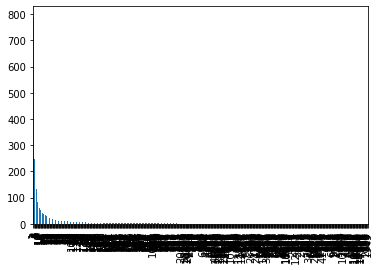

In [17]:
#Frequency plot of the full data set
by_char_df['Count'].value_counts().plot(kind ='bar')

---
Due to the large number of classes, the above plot is difficult to interpret, but it alludes to problem with this data set. We can see from this plot that while some classes have a large amount of observations, the majority of classes have very few observations. Let's explore this further, and visualize the data in a more interpretable way.

---
<a id = 'summary stats'></a>

In [29]:
#printing summary statistics
print(by_char_df.describe())

#Investigating the numbers of observations in the classes
total_less_than(1,by_char_df)
total_less_than(100,by_char_df)
total_greater_than(2000,by_char_df)
total_greater_than(30000,by_char_df)


              Count
count   4328.000000
mean     250.999538
std     1851.491931
min        1.000000
25%        2.000000
50%       10.000000
75%       53.000000
max    41293.000000

Number of characters with 1 or fewer observations: 790
This makes up: 18.25% of the classes

Number of characters with 100 or fewer observations: 3578
This makes up: 82.67% of the classes

Number of characters with 2000 or more observations: 77
This makes up: 1.78% of the classes

Number of characters with 30000 or more observations: 4
This makes up: 0.09% of the classes


We can see above that while some characters such as の have over 41,000 observations, 82.67% of classes have less than 100 observations, with 790 having only a single observation.

In the next cell we will look at the top 20 most frequent characters.

In [19]:
#Investigating the top 20 characters with the highest amount of observations
top_20 = by_char_df.nlargest(20,['Count'])
print(top_20)

#The difference in obsevations between the most frequent and the 20th most frequent
print("\nDifference between the most frequent and 20th most frequent: ",(top_20['Count'].max())-(top_20['Count'].min()))

    Unicode Character  Count
91   U+306E         の  41293
88   U+306B         に  40179
68   U+3057         し  37747
83   U+3066         て  32161
85   U+3068         と  28899
56   U+304B         か  26894
92   U+306F         は  26120
126  U+3092         を  25829
119  U+308A         り  24447
87   U+306A         な  24157
120  U+308B         る  20683
111  U+3082         も  20623
52   U+3044         い  18389
76   U+305F         た  18207
118  U+3089         ら  16582
60   U+304F         く  16242
58   U+304D         き  14549
121  U+308C         れ  13894
107  U+307E         ま  13590
101  U+3078         へ  12797

Difference between the most frequent and 20th most frequent:  28496


Here, we have printed the top 20 most frequent characters in the data set. One thing to note is that all of the characters in the top twenty are "Hiragana" characters. Hiragana characters are used in modern Japanese to write words phonetically and frequently serve grammatical functions such as distinguising a sentence's subject, object, and determining if a sentence is a question or statement.

Hiragana characters are phonetic, and distinct from "Kanji" characters which are ideographic and represent specific ideas/concepts/words. It is therefore not surprising that the top 20 most frequent characters are all Hiragana characters.

We can see that the difference between the most frequent character, の and the 20th most frequent character, へ is 28,496. This demonstrates a tendency to see a rapid drop in character frequency.

<a id = 'visual'></a>
## Visualizing the data

As we saw <a href = '#first_plot'>above</a>, given the large number of classes and the extreme imbalance in the data, it is difficult to visualize the data as a whole in an easily understandable way. However we can see the imbalance in the data visually by examining the top 20 most frequent characters. Below is a plot showing the frequency of the top 20 most frequent characters.

<Figure size 1536x1024 with 0 Axes>

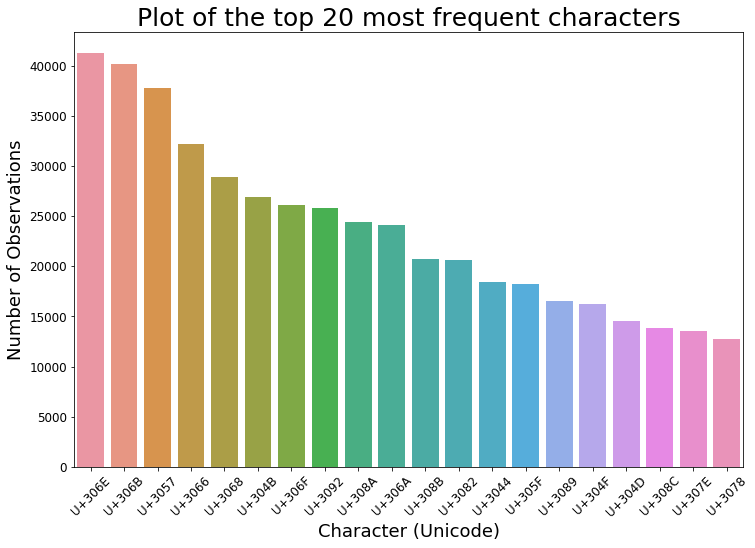

In [20]:
#Plot the top 20 most frequent characters by the amount of observations
plt.figure(num=None, dpi=256, facecolor='w', edgecolor='r')
plt.figure(figsize=(12, 8))
top_20_plot = sns.barplot(x = top_20['Unicode'], y = top_20['Count'])

#Adjust the visual parameters of the plot
top_20_plot.axes.set_title("Plot of the top 20 most frequent characters",fontsize=25)
top_20_plot.set_xlabel("Character (Unicode)",fontsize=18)
top_20_plot.set_ylabel("Number of Observations",fontsize=18)
top_20_plot.tick_params(labelsize=12)
plt.setp(top_20_plot.get_xticklabels(), rotation=45)
plt.savefig('Figures/top_20_plot.png')

plt.show()

The decrease in character frequency follows a constant decline. The above plot also demonstrates the severity of the imbalance in the data with the most frequent character being almost 3 times as frequent as the 20th most frequent character.

---
We will now inspect the inter quartile range visually. We can see <a href = '#summary stats'>above</a> that in terms of character counts, the 75th percentile of character frequency was 53, and the 25th percentile was 2. So we will isolate and investigate the character classes which had between 2 and 53 observations.

In [21]:
#Visualizing the interquartile range

#Isolate the classes with 53 or less, and 2 or more observations
top_iqr = by_char_df['Count'] <= 53
bottom_iqr = by_char_df['Count'] >= 2
iqr = by_char_df[top_iqr & bottom_iqr]

#Sort the values
iqr = iqr.sort_values(['Count'],ascending=False)

#Preview the IQR
print(iqr.head(20))
print("\nTotal amount of characters in the IQR: ",iqr['Count'].sum())
print("\nTotal number of unique characters in the IQR: "+str(iqr.shape[0]))

#Check how many classes have 53 observations and how many have 2
total_equal_to(53,by_char_df)
total_equal_to(2,by_char_df)

#Save a seperate dataframe with only the file lists of characters in the iqr
iqr_raw = my_data[my_data.Unicode.isin(iqr['Unicode'])]
iqr_raw.to_csv('CSVs/IQR_raw.csv', index=False) 

     Unicode Character  Count
179   U+30D5         フ     53
4059  U+9945         饅     53
629   U+537F         卿     53
287   U+4E7E         乾     53
1036  U+5BA4         室     53
3807  U+9285         銅     53
1611  U+653F         政     53
3560  U+8CCA         賊     53
3253  U+86C7         蛇     53
1401  U+616E         慮     53
3937  U+96D1         雑     53
495   U+518A         冊     52
2302  U+732B         猫     52
3744  U+90E1         郡     52
3928  U+96C1         雁     52
3568  U+8CE2         賢     52
3969  U+9759         静     52
2554  U+796D         祭     52
3678  U+8FF0         述     52
853   U+5805         堅     52

Total amount of characters in the IQR:  32446

Total number of unique characters in the IQR: 2459

Number of characters with 53 observations: 11
This makes up: 0.3% of the classes

Number of characters with 2 observations: 388
This makes up: 9.0% of the classes


---
We can see that the interquartile range consists of 2,459 different classes. Unlike the top 20 most frequent characters, we can see by previewing 20 of the characters in the interquartile range that 19 of them are <strong>Kanji</strong> characters (which are ideographic and represent words/concepts rather than just sounds). The one exception is the first character in the preview above: "フ" (pronounced as 'fu')　which is a <strong>katakana</strong> character mostly used in modern Japanese for the purpose of writing foreign loan words phonetically. 

Visualizing the interquartile range in terms of character frequency in a clearly understandable manner poses a challenge. To overcome this, we will group the classes by the number of observations they have, and plot the number of observations, by the number of classes with that number of observations.

For example, there are 11 classes that have 53 observations, and 388 classes that have 2 observations. We will plot this information for each number of observations between 2 and 53.

---

<Figure size 1536x1024 with 0 Axes>

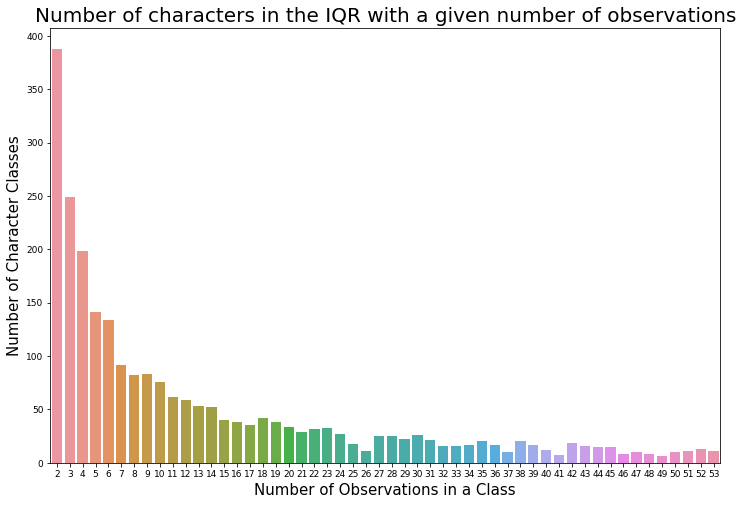

In [22]:
#Group the classes by the amount of observations, showing us how many classes had x observations.
iqr_class_counts = iqr['Count'].value_counts()
iqr_counts = iqr_class_counts.index.values.tolist()
iqr_num_of_classes = iqr_class_counts.tolist()

#Create a plot to visualize the amount of observations each class has within the inter quartile range.
plt.figure(num=None, dpi=256, facecolor='w', edgecolor='r')
plt.figure(figsize=(12, 8))
iqr_plot = sns.barplot(x = iqr_counts, y = iqr_num_of_classes, orient='v')

#Adjust the visual parameters of the plot
iqr_plot.axes.set_title("Number of characters in the IQR with a given number of observations",fontsize=20)
iqr_plot.set_xlabel("Number of Observations in a Class",fontsize=15)
iqr_plot.set_ylabel("Number of Character Classes",fontsize=15)
iqr_plot.tick_params(labelsize=9)
plt.savefig('Figures/IQR_characters_and_observations.png')

plt.show()

---
The plot clearly shows the unbalanced nature of the data within the IQR. We can see that there are 388 characters with only 2 observations, approximately 250 characters with 3 observations, and appoximately 200 characters with only 4 observations.

This trend continues up until around 15 observations, where the amount of characters, with 15 observations or more, drops and remains below 50, with only 11 characters having 53 observations. In other words, the plot shows us that the majority of classes in the IQR have very few observations. In the next cell we look at this in more detail and we will see below that that 1669 characters have 15 or less observations and 790 characters have 15 or more.


In [23]:
#Investigate how many classes in the IQR have 15 observations or more, and how many have less than 15 observations
iqr_freq = iqr.groupby('Count')['Unicode'].size()
iqr_class_counts = iqr['Count'].value_counts()

above_or_equal_to_15 = sum(iqr_class_counts.values[iqr_class_counts.index.values>=15])
below_15 = sum(iqr_class_counts.values[iqr_class_counts.index.values<15])

print(f"Number of classes with 15 observations or more: {above_or_equal_to_15}")
print(f"Number of classes with less than 15 observations: {below_15}")



Number of classes with 15 observations or more: 790
Number of classes with less than 15 observations: 1669


<a id = 'viz conclusions'></a>
## Conclusion from examining the data

Examining the summary statistics and plots above, we can see that the data is highly unbalanced. While the most frequently occuring character (の) has 41,293 observations, out of the 4,328 characters, 790 of them have only 1 observation (making up 18.25% of the total unique characters). 

Additionally 75% of the unique characters have less than 53 observations. By examining the interquartile range closely, we can also see that 790 characters within the interquartile range have less than 15 observations. When we consider this in combination with the 790 characters with only 1 observation, 1,580 out of the 4,328 unique characters (or approximately 36.51%) have less than 15 observations.

Only 1.78% of the unique characters have 2000 or more observations, with 0.69% of the characters having 10,000 or more observations.

This poses an interesting challenge for the problem. Firstly we will need to consider the implications of working with the full data set as it is. 

As there are 790 character classes with only a single observation, this poses a problem as we would be unable to make sure that these classes are represented in both the training and testing set at the same time. A possible solution would be to generate synthetic data through methods such as image augmentation, use this synthetic data to train our model, and then test the model's performance on the real example. However, in such a case we would run the risk of overfitting our models as we would be using data in our test set to generate the sythetic data which the model would be trained on. Other ideas would be to only include these classes in our training set, however this would not be particularly useful as we wouldn't be able to test our model's performance on these characters. For these reasons, the character classes with only one observation will not be included when we are building our actual models.

The other thing to consider is the implications for when it comes to balancing our data. As we saw above, we have 388 character classes with only 2 observations each. On the other hand, our most frequent character の has 41,293 observations. Typically when we run a balancing algorithm, the algorithm will produce enough synthetic samples such that the minority classes have the same number of observations as the majority class. However if we consider a case where both the test and training set are assigned approximately 20,000 instances of の each, the amount of computing power required to balance the 4,328 total character classes in the training set so they all have 20,000 observations would be very demanding. 

For this reason, for our model building, we will only be working with the classes included in the interquartile range. While it would be ideal to work with all classes in the data set, the IQR reflects the key characteristics of the dataset as a whole (its highly imbalanced nature) and also primarily consists of less common Kanji characters (as opposed to the frequently occuring Hiragana characters). Given the subtle differences between these characters and small details which can make differentiating these characters challenging even for humans, this will pose an interesting challenge for our models. 

---


<a id = 'preprocessing'></a>
# Preprocessing the data

In this step, we will preprocess the data so as to make it usable for our models. Our process will focus on the IQR and will consist of splitting the data into training and test sets, balancing our training set by generating synthetic images through augmentation, and applying image processing techniques to simplify our images with the goal of improving overall model performance.

<a id = 'split'></a>
## Splitting the data into training and test groups

In the next cell we will split our data into training and test groups. However, as we are working with 2,459 unique classes, there is a chance that if we simply sample randomly, we could end up with a training and test set with two very different distributions in terms of class representation. We will therefore use stratified sampling to preserve the distribution of each class.

In [30]:
#Create a training and testing set
x_train, x_test, y_train, y_test = train_test_split(iqr_raw['File'], iqr_raw['Unicode'],random_state=42,train_size=0.7,stratify=iqr_raw['Unicode'])

#Check how many unique classes there are in the training and test sets
unique_char = np.unique(y_train, return_counts=False)
#Examine the size of each set
print("The training set has ",str(len(x_train))," observations, with",len(unique_char)," unique characters.")
unique_char = np.unique(y_test, return_counts=False)
print("The test set has ",str(len(x_test))," observations, with",len(unique_char)," unique characters.")

#Convert the sets into Numpy Arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

The training set has  22712  observations, with 2459  unique characters.
The test set has  9734  observations, with 2425  unique characters.


<a id = 'num_class'></a>
We can see that the training and test sets have different numbers of unique characters, meaning that there are some classes which are only represented in our training set. This will cause issues when it comes to building some of our models. So to address this, we will remove any observations in our training set which belong to classes not represented in out test set.

In [31]:
y_new = []
x_new = []

#Create a new training set with classes not represented in the test set removed
for i in range(0,len(y_train)):
    if y_train[i] in y_test:
        y_new.append(y_train[i])
        x_new.append(x_train[i])
        
x_train = np.array(x_new)
y_train = np.array(y_new)

#Double check that the training and test sets have the same number of classes
unique_char = np.unique(y_train)
#Examine the size of each set
print("The training set has ",str(len(x_train))," observations, with",len(unique_char)," unique characters.")
unique_char = np.unique(y_test)
print("The test set has ",str(len(x_test))," observations, with",len(unique_char)," unique characters.")

The training set has  22644  observations, with 2425  unique characters.
The test set has  9734  observations, with 2425  unique characters.


We can now see that the training and test sets have the same number of classes.

At the moment, the x_train and x_test sets only contain lists of file names rather than the images themselves.

In [32]:
print(x_train[0:5])

['./all/200021712/characters/U+96D1/U+96D1_200021712_00020_2_X1500_Y2426.jpg'
 './all/hnsd00000/characters/U+68C4/U+68C4_hnsd004_027_X0823_Y1598.jpg'
 './all/200014685/characters/U+7FA4/U+7FA4_200014685_00018_1_X0932_Y1749.jpg'
 './all/umgy00000/characters/U+43FB/U+43FB_umgy005_018_X0103_Y0945.jpg'
 './all/200004148/characters/U+559A/U+559A_200004148_00082_2_X0232_Y0536.jpg']


In the next section we will start working with the images themselves.

<a id = 'augmentations'></a>
## Examining the Images and generating augmentations

The Kuzushiji data set consists of both full pages from the books, as well as images of the individual characters on each page. Here is a sample image of each.


Example image of a full page:


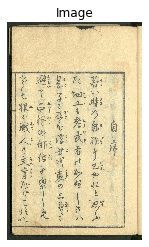


Example image of an individual character:


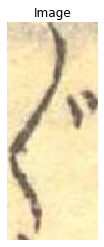

In [33]:
#Load a sample page image
file = Path("sample_page.jpg")
sample_page = plt.imread(file)
print("\nExample image of a full page:")
show_image(sample_page)

#Load a sample character image
file = Path("all/100249476/characters/U+3032/U+3032_100249476_00020_1_X0285_Y0567.jpg")
sample_char = plt.imread(file)
print("\nExample image of an individual character:")
show_image(sample_char)

For the purpose of our model building, we will not be working with the images of the pages, but only working with the images of the individual characters.

Although we are focusing on the interquartile range of the dataset in terms of character frequency, there is still alot of imbalance in the data set. We can see below that approximately 45% of classes in the IQR have less than 6 observations.

In [34]:
#total_less_than(6,unique_charIQR)
six_or_less = sum(iqr_class_counts.values[iqr_class_counts.index.values<=6])
print('Number of classes in the IQR with 6 or less observations:',six_or_less)
print('This accounts for ',round((six_or_less/sum(iqr_class_counts.values))*100,2),'% of classes in the IQR')


Number of classes in the IQR with 6 or less observations: 1110
This accounts for  45.14 % of classes in the IQR


We can also see in the next cell, that after splitting our data into training and testing sets, we have 1168 character classes with less than 6 observations in our training set, and 354 of those classes classes only have a single observation.
<a id = 'class_counts'></a>

In [35]:
#Create a dataframe with just the training set
x_train_df = pd.DataFrame()
x_train_df.insert(loc=0, column='Unicode', value=y_train)
x_train_df.insert(loc=1, column='Files', value = x_train)


#Count the number of observations for each character class in the training set
unicodes = np.array(y_train)
counted_classes = count_characters(unicodes)

#Count the number of classes with less than 6 observations
less_than_6_obs = {char:count for char, count in counted_classes.items() if count < 6}
less_than_6_obs = list(less_than_6_obs.keys())

print("Number of unique characters in training set with less than 6 observations: ",len(less_than_6_obs))
print("This makes up: ",round((len(less_than_6_obs)/len(unique_char))*100,2),"% of classes")
print("\nHighest number of observations in a unique class: ",np.max(list(counted_classes.values())))
print("Lowest number of observations in a unique class: ",np.min(list(counted_classes.values())))

#Count the number of classes with only a single observation
single_in_train = {char:count for char, count in counted_classes.items() if count == 1}
single_in_train = list(single_in_train.keys())

print("\nNumber of classes the in training set with only one observation: ",len(single_in_train))
print("This makes up: ",round((len(single_in_train)/len(unique_char))*100,2),"% of classes")

#Sample the classes to show the differences in character counts
print('\n\nSample of 10 classes and their character counts:')
dict(list(counted_classes.items())[0:10])

Number of unique characters in training set with less than 6 observations:  1168
This makes up:  48.16 % of classes

Highest number of observations in a unique class:  37
Lowest number of observations in a unique class:  1

Number of classes the in training set with only one observation:  354
This makes up:  14.6 % of classes


Sample of 10 classes and their character counts:


{'U+0031': 1,
 'U+0032': 3,
 'U+0039': 2,
 'U+2000B': 11,
 'U+20D45': 7,
 'U+22999': 3,
 'U+241C6': 1,
 'U+242CE': 1,
 'U+24E30': 2,
 'U+24FA3': 1}

___
This will pose an issue when it comes to applying a balancing algorithm. Popular balancing algorithms like Random Oversampling, rely on randomly sampling from minority classes with replacement to generate extra samples for the minority classes. However, if a character only has one observation in the training set, then the algorithm will just sample the same image multiple times, resulting in an overfitted model.

Other algorithms like Synthetic Minority Oversampling Technique (SMOTE), generate synthetic examples by choosing an observation in a minority class and comparing it to its nearest neighbours, with the synthetic observation being a point between the selected observation and its neighbours. However, SMOTE requires that each class has at least 6 observations. If a minority class doesn't have many observations, SMOTE won't be able to the observation's neighbours to generate new samples. In our case, 48% of classes in our test set have less than 6 samples, so SMOTE is not a practical solution. Further more, SMOTE will sample our minority classes until all classes have the same number of observations as the largest class. In our case, the largest class in the training set only has 37 observations, so we may not have enough data when it comes to training our models.

In order to address this, we will use a technique called <strong>augmentation</strong>. Augmentation works by taking a sample image from our classes and slightly augmenting the image in different ways, adjusting things like its brightness, its position, and scale, and then storing the augmented image as a new observation. We will implement this for all classes such that each class has 100 observations. For each augmentation, we will sample a random observation and adjust it slightly with replacement. 

While it is also common to augment images by flipping them horizontally or vertically and rotating them, because we are working with a written language problem, we will not invert the image, as it is assumed that the characters would always be written frontwise. While we will rotate the images slightly, we will restrict the rotations to 10 degrees so as to prevent distorting the characters in an unrealistic manner.
___

Here is a preview of what the augmentations will look like:

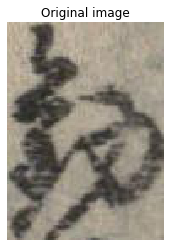

Augmented Images:


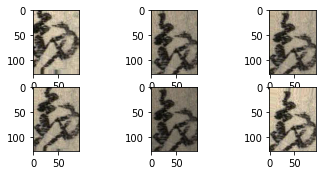

In [36]:
#Original Image
show_image(plt.imread(x_train[38]),"Original image")

#Example of what the augmentations look like
print('Augmented Images:')
example = generate_data(x_train[38],n=6,view='yes')

We will apply our augmentation/balancing algorithm in the next cell. This will generate a set of augmentations for each class such that each class has exactly 100 observations each. This process will take approximately 15 minutes. The details of the <i>augment_classes( )</i> function can be found in the <i>my_functions.py</i> file.

In [22]:
#Takes around 15-20 minutes
#Measure the processing time
start = time.perf_counter()

#Augment the images and store the class labels
augmented_images, augmented_labels = augment_classes(x_train_df, counted_classes, number_of_samples=1)

finish = time.perf_counter()
print(f'Finished generating images in {round(finish-start,2)} seconds')

#Number of images generated
print("Number of synthetic images generated: ",len(augmented_images))

Finished generating images in 824.61 seconds
Number of synthetic images generated:  219856


We have generated 219,856 synthetic images. Let's preview some of the synthetic data we have created through augmentation.

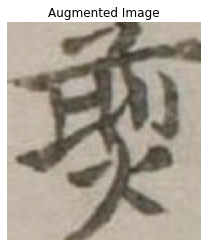

The image's character literal:  𤋎
The Unicode: U+242CE


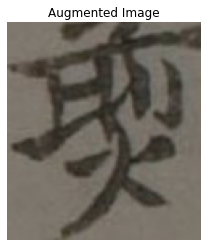

The image's character literal:  𤋎
The Unicode: U+242CE


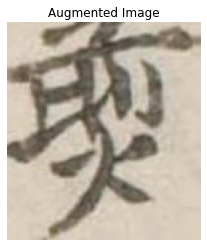

The image's character literal:  𤋎
The Unicode: U+242CE


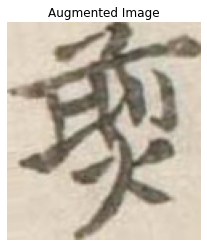

The image's character literal:  𤋎
The Unicode: U+242CE


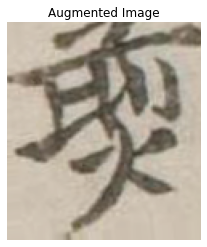

The image's character literal:  𤋎
The Unicode: U+242CE


In [23]:
for i in range(707,712):
    show_image(augmented_images[i][0],"Augmented Image")
    unicode = augmented_labels[i]
    print(f"The image's character literal: ",chr(int(unicode[2:], 16)))
    print(f"The Unicode: {unicode}")

## Processing the images

Now that we have generated some augmented synthetic samples, we will load all of the remaining images in our training and test sets using the file names we have stored and apply several transformations to them in order to use the images with our models. 

Specifically these transformations will involve three steps:

1. We will resize each image so they are all the same size. The reason for this is because for image classifiers, each pixel represents an independent variable. Our models will require values for all of the variables to properly work. The larger the image size the better the quality, however a larger image size also means that the computational time will increase. Given that we are working with handwritten letters with distinct lines, we can compromise some of the quality in favour of improving computation time, because a lot of the smaller details (smudges from brush strokes etc.) are not important in distinguishing the characters from each other. For this reason, we will set the size to 64 by 64 pixels. 


2. We will convert the images from RGB into grayscale. A standared RGB image is represented by three arrays of <i>NxN</i> elements. Where each array represents a colour channel (red, blue, and green), each element corresponds to a pixel, and the element's value represents the pixel intensity of the colour in the image. By converting the images to grayscale, we are reducing this to just one colour channel/one array and cutting computation time significantly.


3. Lastly, we will apply thresholding to make the images completely black and white. Given that our images consist of brushstrokes on a plain paper background, converting the images to black and white is a simple way to isolate the characters in the image. Thresholding works by setting a critical value, and assigning any pixel greater than this value to white, and any pixel less than it to black. This creates a single array consisting of binary values and will make it easier for our models to process. Thresholding will also help address issues such as ink from characters on the opposite side of the page, light smudges, and shadows etc. from interfering with the model's calculations.


Below is an example of each of the transformations with a sample image.

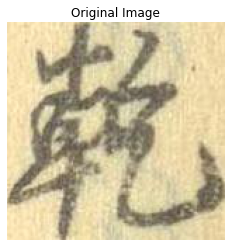

Original image dimensions:  (155, 155, 3)


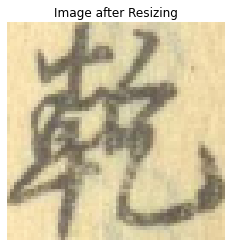

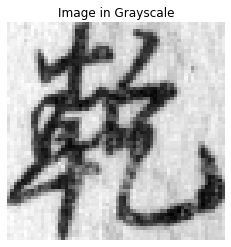

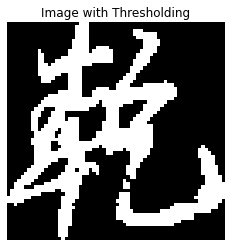

New image dimensions:  (64, 64)


In [24]:
#Original image
sample_char = plt.imread("all/100241706/characters/U+4E7E/U+4E7E_100241706_00029_1_X1774_Y1384.jpg")
show_image(sample_char,"Original Image")
print("Original image dimensions: ",sample_char.shape)

#Resize the image
img_size = 64
sample_char = resize(sample_char,(img_size,img_size))
show_image(sample_char,"Image after Resizing")

#Convert image to grayscale
sample_char = color.rgb2gray(sample_char)
show_image(sample_char,'Image in Grayscale')

#Apply thresholding to the image to make it Black and White
#Find the critical thresholding value
thresh_otsu = threshold_otsu(sample_char)
#Apply thresholding
sample_char = sample_char <= thresh_otsu 
show_image(sample_char, "Image with Thresholding")

print("New image dimensions: ",sample_char.shape)

<a id = 'processing'></a>
## Processing the images in our training and test sets

We will now proceed to process all of the image files in our dataset. We will load the training and test images seperately, starting with our training set. We will use the list of file names in our training set to load the images and perform the transformations described above. To speed up this process, we will use parallel processing. The details of the functions used are included the <i>'my_functions.py'</i> file.

This will return a list of numpy arrays which correspond to the processed images.

In [25]:
#Takes around one minute and produces a list of arrays which match the Y labels and file lists

#Measure the processing time
start = time.perf_counter()

#Apply image processing to the training set
x_train_processed = parallelize_process(x_train)

finish = time.perf_counter()
print(f'Finished image processing in {round(finish-start,2)} seconds')


 22%|██▏       | 4956/22644 [00:00<00:00, 48306.18it/s]

Starting the image processing with 16 processing units.


100%|██████████| 22644/22644 [00:13<00:00, 1693.11it/s]


Closing the pool...
Joining the pool...
Finished image processing in 20.68 seconds


To check that the images have been processed correctly, let's preview the first 5 characters of the training set.

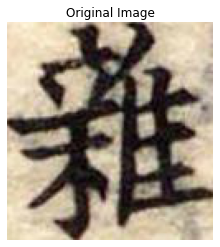

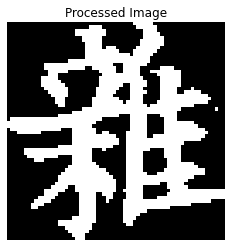

The image's character literal:  雑
The Unicode: U+96D1
The filepath:./all/200021712/characters/U+96D1/U+96D1_200021712_00020_2_X1500_Y2426.jpg


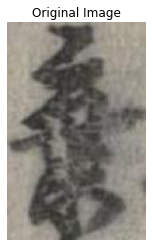

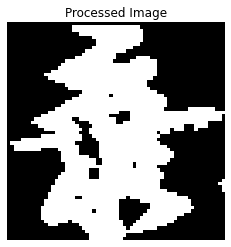

The image's character literal:  棄
The Unicode: U+68C4
The filepath:./all/hnsd00000/characters/U+68C4/U+68C4_hnsd004_027_X0823_Y1598.jpg


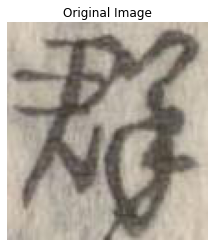

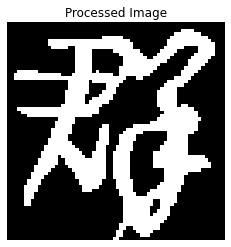

The image's character literal:  群
The Unicode: U+7FA4
The filepath:./all/brsk00000/characters/U+7FA4/U+7FA4_brsk004_033_X1394_Y1824.jpg


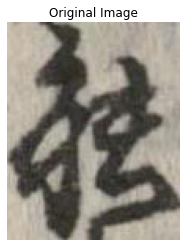

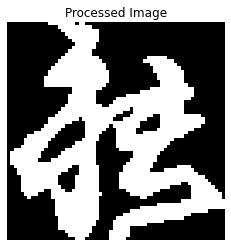

The image's character literal:  䏻
The Unicode: U+43FB
The filepath:./all/umgy00000/characters/U+43FB/U+43FB_umgy005_018_X0103_Y0945.jpg


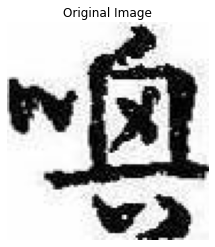

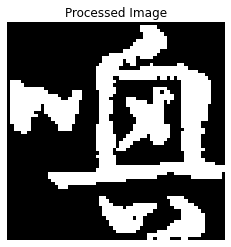

The image's character literal:  喚
The Unicode: U+559A
The filepath:./all/200004148/characters/U+559A/U+559A_200004148_00082_2_X0232_Y0536.jpg


Total Length of original list of file names:  22644
Total Length of list of processed images:  22644


In [26]:
#Preview the processed images in the training set
for i in range(0,5):
    show_image(plt.imread(x_train[i]),"Original Image")
    show_image(x_train_processed[i],"Processed Image")
    unicode = y_train[i]
    print(f"The image's character literal: ",chr(int(unicode[2:], 16)))
    print(f"The Unicode: {y_train[i]}")
    print(f"The filepath:{x_train[i]}")

print("\n\nTotal Length of original list of file names: ",len(x_train))
print("Total Length of list of processed images: ",len(x_train_processed))

We can see that overall, the lines and shapes of the characters have been preserved after processing them. While the second transformed image is not particularly well defined, we can also see that the original image is rather poor quality as well, so transforming the images does not seem to have resulted in information loss.

## Processing the test images

We will now perform the same process for the images in our test set.

In [27]:
#Takes around 15 seconds and produces a list of arrays which match the Y labels and file lists

#Measure the processing time
start = time.perf_counter()

#Apply image processing to the training set
x_test_processed = parallelize_process(x_test)

finish = time.perf_counter()
print(f'Finished image processing in {round(finish-start,2)} seconds')

  0%|          | 0/9734 [00:00<?, ?it/s]

Starting the image processing with 16 processing units.


100%|██████████| 9734/9734 [00:06<00:00, 1555.66it/s]


Closing the pool...
Joining the pool...
Finished image processing in 11.21 seconds


Again we will double check the first few images to make sure they have been processed correctly and the labels match.

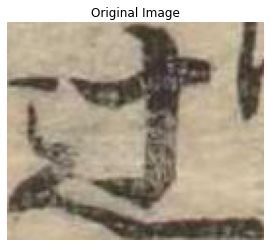

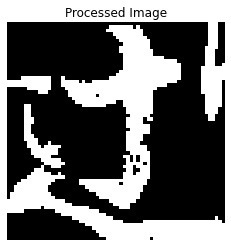

The image's character literal:  辻
The Unicode: U+8FBB
The filepath:./all/200003076/characters/U+8FBB/U+8FBB_200003076_00065_2_X1151_Y2797.jpg


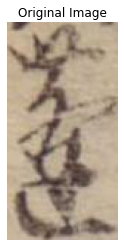

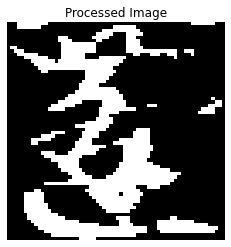

The image's character literal:  蓬
The Unicode: U+84EC
The filepath:./all/200015843/characters/U+84EC/U+84EC_200015843_00085_2_X0474_Y0629.jpg


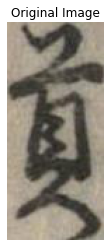

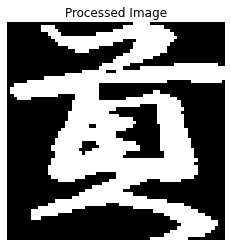

The image's character literal:  貢
The Unicode: U+8CA2
The filepath:./all/hnsd00000/characters/U+8CA2/U+8CA2_hnsd002_006_X0925_Y0379.jpg


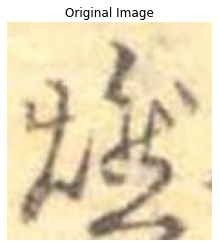

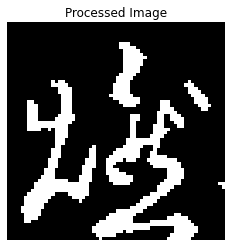

The image's character literal:  燃
The Unicode: U+71C3
The filepath:./all/100249476/characters/U+71C3/U+71C3_100249476_00014_2_X0973_Y0772.jpg


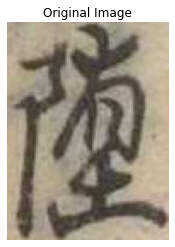

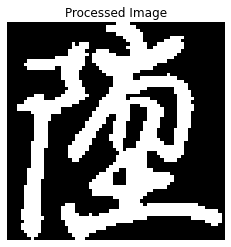

The image's character literal:  堕
The Unicode: U+5815
The filepath:./all/200014740/characters/U+5815/U+5815_200014740_00082_1_X0148_Y1843.jpg


Total Length of original list of file names:  9734
Total Length of list of processed images:  9734


In [28]:
#Preview the images in the test set
for i in range(0,5):
    show_image(plt.imread(x_test[i]),"Original Image")
    show_image(x_test_processed[i],"Processed Image")
    unicode = y_test[i]
    print(f"The image's character literal: ",chr(int(unicode[2:], 16)))
    print(f"The Unicode: {y_test[i]}")
    print(f"The filepath:{x_test[i]}")

print("\n\nTotal Length of original list of file names: ",len(x_test))
print("Total Length of list of processed images: ",len(x_test_processed))

## Processing the Augmented images

We will now process the augmented images that we generated as well, and add them to the training data set. We have also stored their corresponding labels and will add them to the y_train set appropriately.

In [29]:
#Process the Augmented Images
#Takes around 7-8 minutes

#Measure the processing time
start = time.perf_counter()

#Process the augmented images
processed_augmentations = []
for i in range(0,len(augmented_images)):
    processed_augmentations.append(process_images(augmented_images[i][0]))
        
finish = time.perf_counter()
print(f'Finished processing images in {round(finish-start,2)} seconds')

Finished processing images in 392.51 seconds


Here is a preview of a few of the images to make sure they have been processed correctly.

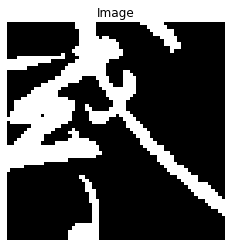

Label:  U+22999
The image's character literal:  𢦙


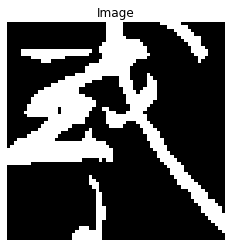

Label:  U+22999
The image's character literal:  𢦙


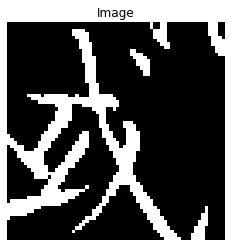

Label:  U+22999
The image's character literal:  𢦙


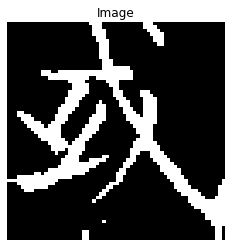

Label:  U+22999
The image's character literal:  𢦙


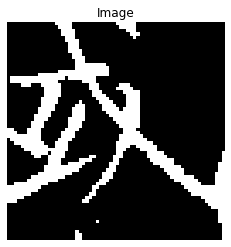

Label:  U+22999
The image's character literal:  𢦙


In [30]:
for i in range(501,506):
    show_image(processed_augmentations[i])
    print("Label: ",augmented_labels[i])
    print(f"The image's character literal: ",chr(int(augmented_labels[i][2:], 16)))

Now we can add the augmented images to our training data set.

In [31]:
#Add the augmented labels to the training set
y_train = list(y_train)
y_train = y_train + augmented_labels
y_train = np.array(y_train)

#Add the augmented images to the training set
x_test = x_test_processed
x_train = x_train_processed + processed_augmentations

We can now see that the classes that we <a href = '#class_counts'>previewed earlier</a> have 100 observations each.

In [32]:
characters = np.array(y_train)
counted = count_characters(characters)

print(f"Total unique character classes: {len(unique_char)}")
print(f"Total number of observations in training set: {characters.shape[0]}")
dict(list(counted.items())[0:10])

Total unique character classes: 2425
Total number of observations in training set: 242500


{'U+0031': 100,
 'U+0032': 100,
 'U+0039': 100,
 'U+2000B': 100,
 'U+20D45': 100,
 'U+22999': 100,
 'U+241C6': 100,
 'U+242CE': 100,
 'U+24E30': 100,
 'U+24FA3': 100}

Now that we have completed the preprocessing of our data and balancing our dataset, we will proceed to build our predictive models.
___

<a id = 'models'></a>
# Model Building

Before we start model building, we will briefly discuss the method we will use for assessing the performance of our models. Although the intuitive metric to use for classification problems would be <strong>Accuracy</strong> (i.e. the amount of correct predictions over the amount of total predictions), there are some issues with this.

Particularly when we are working with multiclass problems in which the dataset is unbalanced, using accuracy as a metric can be problematic as the model may tend to only predict the majority classes and ignore the minority classes, as this would have a higher chance of returning more correct predictions. However, this method is not particularly useful for the purpose of using a model to make predictions.

To address this, we will be using the <strong>F1 micro score</strong> to assess and compare the performance of our models. The F1 score is a metric which takes into account both <strong>precision</strong> (the ratio of the 'true positive' predictions of a class over the total predictions for a given class) and <strong>recall</strong> (the ratio of the 'true positive' predictions over the sum of the total occurances of the class in the test set). In other words, the precision is a measure of how correct our model's predictions are, and recall is a measure of how many occurances of a class our model is able to correctly identify.
    
$Precision = \frac{tp}{tp + fp}$
    
$Recall = \frac{tp}{tp + fn}$

The F1 score is a weighted average between a model's precision and accuracy. It takes both false positives and false negatives into account. It is a score between 0 and 1 where 1 indicates that a model predicted a particular class perfectly, and 0 indicates that it did not correctly predict any occurances of a class.

It is defined as 2 times the ratio of the product of the precision and recall over the sum of the precision and recall:

$F_1 = 2*\frac{Precision*Recall}{Precision + Recall}$

The <strong>F1 micro score</strong> is the average of F1 scores across all classes. It is particularly useful for unbalanced data sets as it measures how well a model is performing across all classes, taking them all into account. This means that it is less susceptible to class bias in cases where there are some classes with a large number of occurances and others with very few, and it can be used to avoid the issues with <strong>accuracy</strong>.

<a id = 'knn_model'></a>
## KNN Model Building


The main focus of this project will involve working with convolutional neural network (CNNs) architectures, as CNNs have been a well documented method for image recognition tasks. However, for the purpose of comparing the effectiveness of CNNs, we will also use a standard machine learning method as a way of judging the performance of our CNN models. 

Among the [benchmark models featured by the ROIS-DS Center for Open Data in the Humanities (CODH)](https://github.com/rois-codh/kmnist), the organisation has included a K-nearest neighbours model which has achieved test accuracy scores of 92.10% for the <i>kuzushiji MNIST</i> data set and 83.65% for the <i>kuzushiji-49</i> dataset. The organisation has not featured the performance of any algorithms on the full <i>kuzushiji dataset</i>, however, given its performance on the smaller versions of the dataset, along with the algorithm's relative simplicity, it serves as a good base for the sake of comparison to judge the performance of our CNN models.

The main hyperparameters in a KNN model are the number of neighbours that the model uses, the weights associated with each neighbour when they 'vote', and the distance metric used. In this case we will try 10 different settings for K, but will keep the distance fixed at <strong>'euclidean'</strong> and weights fixed at <strong>'distance'</strong> to save on computation time. To select the best model, we will use the F1 micro score as a metric.

---
Before running the KNN model, we will need to convert our x_train and x_test sets into 2 dimensions. These dimensions will represent:

1. The number of observations
2. The number of features (pixels)
    
At the moment, our sets are in 3 dimensions representing:

1. The number of observations
2. The height of images in pixels
3. The width of images in pixels

To convert our sets into 2 dimensions, we can multiply the pixel height and width.

In [33]:
#View the training set in 3 dimensions
x_train = np.array(x_train)
print('x_train shape in 3 dimensions:',x_train.shape)

#Convert the training set to 2 dimensions
n = x_train.shape[0]
pixel_size = x_train.shape[1]
x_train = x_train.reshape((n,pixel_size*pixel_size))
x_train = x_train.astype(int)


#View the test set in 3 dimensions
x_test = np.array(x_test)
print('x_test shape in 3 dimensions:',x_test.shape)

#Convert the test set to 2 dimensions
n = x_test.shape[0]
pixel_size = x_test.shape[1]
x_test= x_test.reshape((n,pixel_size*pixel_size))
x_test = x_test.astype(int)

print('\nx_train shape in 2 dimensions:',x_train.shape)
print('x_test shape in 2 dimensions:',x_test.shape)

x_train shape in 3 dimensions: (242500, 64, 64)
x_test shape in 3 dimensions: (9734, 64, 64)

x_train shape in 2 dimensions: (242500, 4096)
x_test shape in 2 dimensions: (9734, 4096)


We will now run 10 KNN models with 10 different values for K. This process will take approximately 30 minutes. 


If you wish to skip this section and view the results of a previously fitted model, feel free to skip the following cells until you reach the sub heading: '<strong>Results of the KNN model</strong>'

In [39]:
#Feel free to skip this cell if you would like to load the results of a 
#previously trained model

#Takes around 25-30 minutes
start_total = time.perf_counter()

#Set parameters to try and lists to store the results
k = [2,4,6,8,10,15,20,50,80,100]
knn_f1 = []
knn_acc = []
knn_prec = []
knn_recall = []

print('KNN Classifier\n')

#For each value of k we are testing
for i in range(0,len(k)):
    #Fit a KNN model and use it to predict the data
    knn = KNeighborsClassifier(n_neighbors=k[i],weights='distance',metric='euclidean')
    knn.fit(x_train,y_train)
    y_pred_knn = knn.predict(x_test)
    
    #Show the results
    print(f'K = {k[i]}')
    knn_f1.append(metrics.f1_score(y_test, y_pred_knn, average='micro'))
    knn_acc.append(metrics.accuracy_score(y_test, y_pred_knn))
    knn_prec.append(metrics.precision_score(y_test, y_pred_knn,average='micro'))
    knn_recall.append(metrics.recall_score(y_test, y_pred_knn,average='micro'))

    print(f'K = {k[i]} F1 Micro Score:',knn_f1[i])
    print(f'K = {k[i]} Accuracy Score:',knn_acc[i])
    print(f'K = {k[i]} Precision Score:',knn_prec[i])
    print(f'K = {k[i]} Recall Score:',knn_recall[i])
    print('-------------------------\n')


finish = time.perf_counter()
print(f'Finished building all KNN models in {round(finish-start_total,2)} seconds')

KNN Classifier

K = 2
K = 2 F1 Micro Score: 0.5079104170947195
K = 2 Accuracy Score: 0.5079104170947195
K = 2 Precision Score: 0.5079104170947195
K = 2 Recall Score: 0.5079104170947195
-------------------------

K = 4
K = 4 F1 Micro Score: 0.4906513252516951
K = 4 Accuracy Score: 0.4906513252516951
K = 4 Precision Score: 0.4906513252516951
K = 4 Recall Score: 0.4906513252516951
-------------------------

K = 6
K = 6 F1 Micro Score: 0.47318676802958703
K = 6 Accuracy Score: 0.47318676802958703
K = 6 Precision Score: 0.47318676802958703
K = 6 Recall Score: 0.47318676802958703
-------------------------

K = 8
K = 8 F1 Micro Score: 0.45829052804602427
K = 8 Accuracy Score: 0.45829052804602427
K = 8 Precision Score: 0.45829052804602427
K = 8 Recall Score: 0.45829052804602427
-------------------------

K = 10
K = 10 F1 Micro Score: 0.4483254571604685
K = 10 Accuracy Score: 0.44832545716046845
K = 10 Precision Score: 0.44832545716046845
K = 10 Recall Score: 0.44832545716046845
---------------

<Figure size 1536x1024 with 0 Axes>

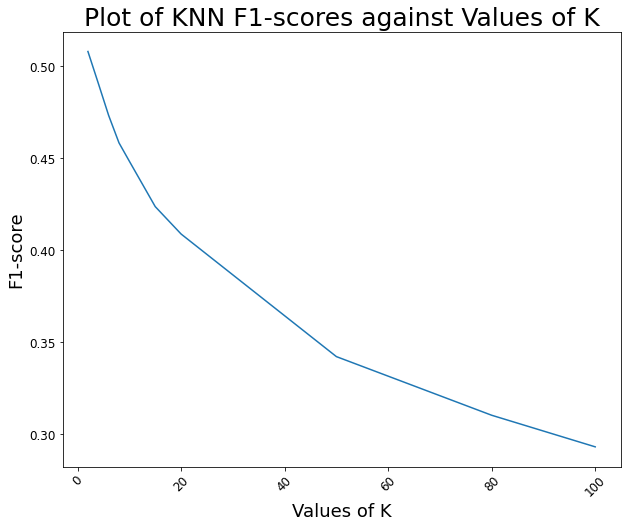

In [40]:
#Please skip this cell if you skipped the previous cell

#Create a plot visualizing the F1-scores for each value of K
plt.figure(num=None, dpi=256, facecolor='w', edgecolor='r')
plt.figure(figsize=(10, 8))
knn_plot1 = sns.lineplot(x = k, y = knn_f1)

#Adjust the visual parameters of the plot
knn_plot1.axes.set_title("Plot of KNN F1-scores against Values of K",fontsize=25)
knn_plot1.set_xlabel("Values of K",fontsize=18)
knn_plot1.set_ylabel("F1-score",fontsize=18)
knn_plot1.tick_params(labelsize=12)
plt.setp(knn_plot1.get_xticklabels(), rotation=45)
plt.savefig('Figures/knn_plot1.png')

plt.show()

___
As we can see the best model had a value of k = 2, with a F1 micro score of approximately 0.50. We will now fit a KNN model with k = 2 and use it to try to predict the test data. In the next section we will examine the model's performance in more detail. 

If you would like to skip the process of fitting the model, you can load the results of a previously fitted model by skipping the next cell to the section labelled: '<strong>Results of the KNN model</strong>'. 

Please note that if you decide <strong>not</strong> to skip the next section, you should uncomment the line in the next cell which saves the results of the model. Please be aware however, that the results/numbers described in the following section may be different from what the model predicts if you do decide to run a new model. 
___

In [41]:
#Feel free to Skip if you wish to use the results from a previous model

#Takes around 3 minutes
start_total = time.perf_counter()

#Fit the model and use it to predict the test labels
knn = KNeighborsClassifier(n_neighbors=2,weights='distance',metric='euclidean')
knn.fit(x_train,y_train)
y_pred_knn = knn.predict(x_test)

finish = time.perf_counter()
print(f'Finished building the KNN model in {round(finish-start_total,2)} seconds')

#Uncomment the next line to overwrite the results of a previous KNN
#np.savetxt('CSVs/y_pred_KNN.csv', y_pred_knn, fmt='%s')

Finished building the KNN model in 224.03 seconds


<a id = 'knn_results'></a>
## Results of the KNN model

In this section we will examine the performance of the KNN model in more detail. In order to assess its performance we will use the model's F1 micro score.

In [34]:
#Load the predictions from a previous KNN model
y_pred_knn = pd.read_csv('CSVs/y_pred_KNN.csv',header=None)
y_pred_knn = np.array(y_pred_knn[0])

In [35]:
#Check the model's metrics scores
knn_f1 = round(metrics.f1_score(y_test, y_pred_knn, average='micro'),3)
knn_acc = round(metrics.accuracy_score(y_test, y_pred_knn),3)
knn_prec = round(metrics.precision_score(y_test, y_pred_knn,average='micro'),3)
knn_recall = round(metrics.recall_score(y_test, y_pred_knn,average='micro'),3)

print('KNN F1 Micro Score:',knn_f1)
print('KNN Accuracy Score:',knn_acc)
print('KNN Precision Score:',knn_prec)
print('KNN Recall Score:',knn_recall)

#Store the model's F1 score for comparison with future models
all_models = []
all_models_f1 = []
all_models.append('KNN model')
all_models_f1.append(knn_f1)

KNN F1 Micro Score: 0.508
KNN Accuracy Score: 0.508
KNN Precision Score: 0.508
KNN Recall Score: 0.508


We can see that overall, the model had an F1 micro score of 0.508 and accuracy of 50%. Below we can see a report with the details showing the precision, recall, f1-score, and support (the number of occurances) for each class.

In [36]:
knn_results = metrics.classification_report(y_test,y_pred_knn,zero_division=1)
print(knn_results)

              precision    recall  f1-score   support

      U+0031       0.17      1.00      0.29         1
      U+0032       1.00      1.00      1.00         1
      U+0039       0.50      1.00      0.67         1
     U+2000B       0.67      0.80      0.73         5
     U+20D45       0.60      1.00      0.75         3
     U+22999       0.20      1.00      0.33         1
     U+241C6       1.00      1.00      1.00         1
     U+242CE       1.00      1.00      1.00         1
     U+24E30       1.00      1.00      1.00         1
     U+24FA3       1.00      0.00      0.00         1
     U+2564A       0.50      1.00      0.67         1
     U+25877       1.00      0.00      0.00         1
      U+25A0       0.50      1.00      0.67         5
      U+25B3       0.70      1.00      0.82        14
     U+25E2E       0.00      0.00      0.00         1
     U+25FFB       0.33      1.00      0.50         1
     U+27752       1.00      0.00      0.00         1
     U+28263       0.50    

We can also see below, that a number of classes in the test set were not predicted by the model at all:

In [37]:
#Get classes that had no predictions
no_predictions = set(y_test) - set(y_pred_knn)
print('Number of classes that were not predicted by the model:',len(no_predictions))
print(round(len(no_predictions)/2425,4)*100, '% of the total number of classes in the test set had no predictions.')

Number of classes that were not predicted by the model: 500
20.62 % of the total number of classes in the test set had no predictions.


In order to get a better understanding of which classes are not being predicted by the model, let's look at the number of observations in these classes.

In [38]:
#Get unique character classes and counts of each class
y_test_counted = count_characters(y_test)

observations = []
no_predictions = list(no_predictions)

#Check how many of the classes with no predictions originally 
#had only 1 non-synthetic observation in the training set

not_predicted_synthetic_knn = []
for i in range(0,len(no_predictions)):
    if no_predictions[i] in single_in_train:
        not_predicted_synthetic_knn.append(no_predictions[i])
        

#Get the number of observations in the test set
#for classes that were not predicted by the model

for i in range(0,len(no_predictions)):
    observations.append(y_test_counted.get(no_predictions[i]))

#Summarize the information

print('Total classes with no predictions:',len(observations))
print('Of these classes',len(not_predicted_synthetic_knn),'originally had a single non-synthetic observation.')
print('\nMax number of observations in classes with no predictions:',np.max(observations))
print('Min number of observations in classes with no predictions:',np.min(observations))
print('\nAverage number of observations in classes with no predictions:',round(np.mean(observations),2))

print(f'\nMode of observations:{stats.mode(observations).mode[0]},',\
      f' with:{stats.mode(observations).count[0]}',\
      f' instances ({round(stats.mode(observations).count[0]/len(observations),2)*100}% of classes)')


Total classes with no predictions: 500
Of these classes 188 originally had a single non-synthetic observation.

Max number of observations in classes with no predictions: 8
Min number of observations in classes with no predictions: 1

Average number of observations in classes with no predictions: 1.32

Mode of observations:1,  with:403  instances (81.0% of classes)


We can see above that the majority (81%) of the classes which were not predicted at all by the model had only one observation in the test set. However, we can also see that there were some classes with more than one observation, with some classes having as many as 8 observations.

We can also see that out of the 500 total classes which the model did not predict, 188 of those classes were classes which only had a single non-synthetic observation in the training data set. In otherwords, 188 out of the 354 classes that we only had a single observation for in the training set were not predicted at all by the model.

Let's examine the classes with only one observation in the test set in more detail:

In [39]:
#Count the total number of classes in the test set with only one observation
single_obs = 0
classes, counts = count_characters(y_test,return_dict=False)
for i in range(0,len(y_test_counted.values())):
    if(counts[i] ==1):
        single_obs +=1

print('Total classes in y_test with only a single observation:',single_obs)
print(f'\nThe model did not have any predictions for {stats.mode(observations).count[0]} out of the {single_obs}',\
      f'classes with one observation in the test set ({round(stats.mode(observations).count[0]/single_obs,3)*100}%).')

Total classes in y_test with only a single observation: 942

The model did not have any predictions for 403 out of the 942 classes with one observation in the test set (42.8%).


We can see that although the model had difficulty making predictions for 403 out of the 942  classes with only one observation in the test set, the model was still able to make predictions for over 57% of the classes that had only one observation. This is important as it demonstrates that although the data is highly imbalanced and the training set is largely composed of synthetic data sample, the model is not ignoring minority classes completely.

Now, let's examine the F1-scores for the individual classes in some more detail.

In [40]:
#Store our results as a dictionary
knn_results = metrics.classification_report(y_test,y_pred_knn,output_dict=True,zero_division=1)

#Extract the f1 scores, labels, and number of observations as 3 lists
knn_f1_list = []
knn_result_labels = []
knn_support = []

for i in range(0,len(unique_char)):
    if(unique_char[i] in knn_results.keys()):
       knn_result_labels.append(unique_char[i])
       knn_f1_list.append(knn_results.get(unique_char[i]).get('f1-score'))
       knn_support.append(knn_results.get(unique_char[i]).get('support'))

#Summarize information    
print(examine_f1(knn_result_labels,knn_f1_list,knn_support,1.0,'equal'))
print(examine_f1(knn_result_labels,knn_f1_list,knn_support,0.6))
print(examine_f1(knn_result_labels,knn_f1_list,knn_support,0.5,'less'))
print(examine_f1(knn_result_labels,knn_f1_list,knn_support,0.0,'equal'))


#Get the F1 scores for classes that only had one non-synthetic observation in the training set
synth_label_knn = []
synth_f1_knn = []

for i in range(0,len(single_in_train)):
    if single_in_train[i] in knn_results.keys():
        synth_label_knn.append(single_in_train[i])
        synth_f1_knn.append(knn_results.get(single_in_train[i]).get('f1-score'))

#Inspect results of classes that only have a single real observation in the training set
count = 0
for i in range(0,len(synth_f1_knn)):
    if synth_f1_knn[i] == 1.0:
        count+=1

print("Mean f1-score for classes with only one non-synthetic sample in training set:",round(np.mean(synth_f1_knn),3))
print("Number of classes with only one non-synthetic sample with a perfect f1-score:",count)

        

Total classes with an f1 score equal to 1.0: 186
Average number of observations per class:1.42

Total classes with an f1 score greater than or equal to 0.6: 792
Average number of observations per class:5.45

Total classes with an f1 score less than or equal to 0.5: 1490
Average number of observations per class:2.81

Total classes with an f1 score equal to 0.0: 860
Average number of observations per class:1.49

Mean f1-score for classes with only one non-synthetic sample in training set: 0.201
Number of classes with only one non-synthetic sample with a perfect f1-score: 49


___
The KNN model predicted 186 classes perfectly. For these classes, the average number of observations in the test set was 1.42, suggesting that a large number of these classes only have a single observation in the test set.

The model predicted 792 classes with an f1 score of 0.6 or higher, indicating moderate or better performance.

However, the model predicted 1490 classes with an f1 score of 0.5 or less, and 860 of these classes had an f1-score of zero.

The mean f1-score for classes that only had a single non-synthetic observation in the original training set is 0.201. The KNN also had a perfect f1-score for 49 classes that only had a single non-synthetic sample.
____
Below is a plot of the average f1-score across classes grouped by the number of observations in the test data set (support).

<Figure size 1536x1024 with 0 Axes>

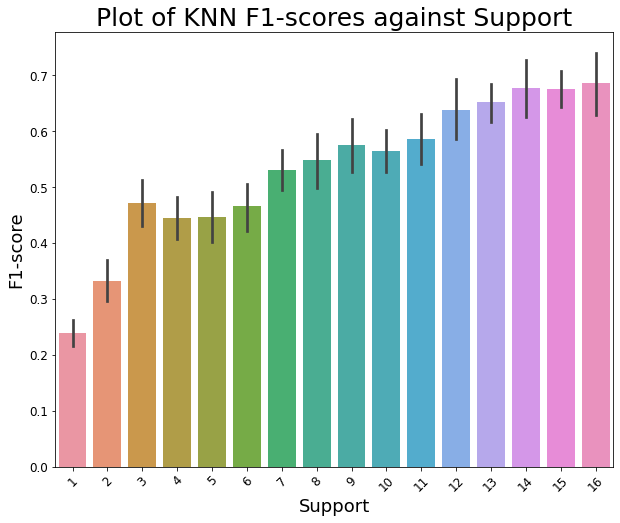

Average f1-score for classes with one observation: 0.24
Average f1-score for classes with two observations: 0.33


In [41]:
#Plot of average f1-score across classes grouped by number of observations in test data
plt.figure(num=None, dpi=256, facecolor='w', edgecolor='r')
plt.figure(figsize=(10, 8))
knn_plot2 = sns.barplot(x = knn_support, y = knn_f1_list)

#Adjust the visual parameters of the plot
knn_plot2.axes.set_title("Plot of KNN F1-scores against Support",fontsize=25)
knn_plot2.set_xlabel("Support",fontsize=18)
knn_plot2.set_ylabel("F1-score",fontsize=18)
knn_plot2.tick_params(labelsize=12)
plt.setp(knn_plot2.get_xticklabels(), rotation=45)
plt.savefig('Figures/knn_plot2.png')

plt.show()

print("Average f1-score for classes with one observation:",round(average_f1(1,knn_support,knn_f1_list),2))
print("Average f1-score for classes with two observations:",round(average_f1(2,knn_support,knn_f1_list),2))

We can see from the above plot, that as the amount of observations in the test set (support) increases, the average f1-score tends to be higher. However, we can also see that the average f1-score for classes with a single observation was 0.23 and 0.35 for classes with two observations. 

This suggests that although the model is better at classifying majority classes, it is not completely ignoring minority classes and still correctly predicting a few classes with only one observation in the test set. For our next few models we will try to build more sophisticated models to help with identifying minority classes.
___

<a id ='cnns'></a>
## Convolutional Neural Networks

For our next few models we will be experimenting with Neural Networks. Specifically, we will focus on using Convolutional Neural Networks (CNNs) which are a popular method for image classification tasks. We will be experimenting with 11 CNN architectures in total. After we have built our architectures we will try to improve the best performing one by adjusting its hyperparameters.

The main architectures we will try will be:
* Simple CNN
* Simple CNN with dropout
* Simple CNN with Inception module(s)
* ResNet34 CNN
* Two ResNet34 CNNs with dropout
* ResNet50 CNN
* Two ResNet50 CNNs with dropout

We will start by building a simple CNN as a baseline and then experimenting with other network architectures to see if we can improve upon the results. However, first we will need to reformat our data sets.

### Format data for Neural Networks

In order to use neural networks, we will need to make sure the x_train and x_test sets are correctly formatted into 4 dimensions, where the dimensions represent:

1. The amount of images
2. The Image's height in pixels
3. The Image's width in pixels
4. The amount of colour channels

We will therefore need to convert the arrays into a shape of (n,64,64,1). At the moment our arrays are in 2d form: (n,4096), where 4096 is the total number of pixels (64*64).

We will therefore take the square root of 4096 and add an extra dimension equal to one in order to convert our arrays into 4D form.

In [42]:
#Preview the training set in 2 dimensions
pixels = x_train.shape[1]
n = x_train.shape[0]

print('x_train in 2 dimensions:',x_train.shape)
print('x_test in 2 dimensions:',x_test.shape)

#Reshape the training set into 3 dimensions
x_train = x_train.reshape(n,int(math.sqrt(pixels)),int(math.sqrt(pixels)))
x_train = x_train.astype(int)

#Add an extra dimension (representing the amount of colour channels) to convert into a 4d array
x_train = np.expand_dims(x_train,-1)

#Preview the test set in 2 dimensions
pixels = x_test.shape[1]
n = x_test.shape[0]

#Reshape the test set into 3 dimensions
x_test = x_test.reshape(n,int(math.sqrt(pixels)),int(math.sqrt(pixels)))
x_test = x_test.astype(int)

#Convert the test set into a 4d array
x_test = np.expand_dims(x_test,-1)

print("\nx_train in 4 dimensions:",x_train.shape)
print("x_test in 4 dimensions:",x_test.shape)

x_train in 2 dimensions: (242500, 4096)
x_test in 2 dimensions: (9734, 4096)

x_train in 4 dimensions: (242500, 64, 64, 1)
x_test in 4 dimensions: (9734, 64, 64, 1)


The y_train and y_test sets representing our character classes will also need to be converted to integers in order to use them with the neural networks. At the moment, they are still two lists of Unicodes. To convert them to integers, we will use 'One hot Encoding'. 

We will also do the same for the list of classes which only had a single non-synthetic observation in the training set so we can analyze the results in more detail later.

In [43]:
#Encode the train labels
label_encoder = OneHotEncoder()
labels = y_train.reshape(-1,1)
label_encoder.fit(labels)
Y_train = label_encoder.transform(labels)

#Encode the test labels
labels = y_test.reshape(-1,1)
label_encoder.fit(labels)
Y_test = label_encoder.transform(labels)

print('y_train before one hot encoding:',y_train[0:5])
print('y_train after one hot encoding:',Y_train[0:5])

#Encode the list of classes which only had a single non-synthetic example 
single = np.array(single_in_train)
single = single.reshape(-1,1)

single = label_encoder.transform(single)

y_train before one hot encoding: ['U+96D1' 'U+68C4' 'U+7FA4' 'U+43FB' 'U+559A']
y_train after one hot encoding:   (0, 2199)	1.0
  (1, 985)	1.0
  (2, 1567)	1.0
  (3, 83)	1.0
  (4, 357)	1.0


Now, to save us the trouble of constantly specifying the shape of the input to the neural networks and the number of classes for the network to classify, we will specify them here.

The input shape should be a 3 dimensional array representing:

1. The Image's height in pixels
2. The Image's width in pixels
3. The number of colour channels

The number of classes, as we saw <a href = '#num_class'>above</a>, is 2425.

In [44]:
input_shape = (64,64,1)
num_classes = 2425

<a id = 'baseline'></a>
### Building a baseline CNN

Our first CNN is a simple architecture which consists of 3 convolutional layers. The layers will have kernel sizes of <i>3x3</i>, <i>5x5</i>, and <i>7x7</i> pixels respectively. The reason for this is to encourage the model to examine localized image features first and gradually examine higher level features at the deeper layers. Each convolutional layer will be followed by a maxpooling layer to reduce the dimensionality of the outputs of our convolutional layers and therefore reduce the number of trainable parameters and save on computation. 

All layers will have 'relu' activation functions, and the number of filters for the convolutional layers will be 32, 64, and 128 respectively with the final dense layer before the output having 64 nodes. This model will act as a baseline from which we will try to improve our model's performance.

In [45]:
#Define the architecture of the baseline CNN
cnn1 = Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Conv2D(64, kernel_size=(5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Conv2D(128, kernel_size=(7, 7), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


cnn1.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         401536    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)            

We can see that our baseline model has a total of 9 layers with 684,537 trainable parameters. For our optimizing algorithm, we will specify it as the Adaptive Moment Estimation (Adam) optimizer. 

In [46]:
opt = Adam(learning_rate=0.001)


We will also specify a callback feature which will automatically stop our model training once it stops improving in performance. The criteria for stopping the training will be if the validation loss stops decreasing after 5 epochs. The validation loss is a measure of how poorly the model is predicting the classes (with a value of 0.0 indicating that the model is predicting the classes perfectly). We are therefore specifying that the model will stop training if it fails to improve in performance after 5 epochs.

In [47]:
early_stop = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 

We will now compile our model, setting the loss function and metrics.

In [48]:
cnn1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Finally, before we actually fit the model, we will create a validation set, so we can use it to check the performance of the model while training, without exposing the model to our test data. We will allocate 20% of the training set for validation and will use this validation set for all of our models.

In [49]:
#Split the data into training and validation sets
x_train_partial, x_validation, y_train_partial, y_validation = train_test_split(x_train, Y_train, train_size=0.8,test_size=0.2, random_state=123)


In [50]:
print('Number of observations in training set:',x_train_partial.shape[0])
print('Number of observations in validation set:',x_validation.shape[0])

Number of observations in training set: 194000
Number of observations in validation set: 48500


Now that our model is compiled and we have created a validation set, we can start training our first CNN model. This should take around 10 minutes. However, I have also saved a model that I have pretrained as a file called <i>'Baseline_cnn.h5'</i>. If you would like to skip the training process, feel free to skip the next two cells and go directly to the cell with the code:

        cnn1_f1 = evaluate_model('Baseline_cnn.h5',x_train,Y_train,x_test,Y_test)

All future CNNs will be saved in this format too. 

Please note that if you do decide to train the model, you can view the model's progress as output by setting <i>'verbose = 1'</i> in the cell below. You should also uncomment the line in the next cell to save the new weights.

In [53]:
#You can skip this cell if you want to skip the training
#Train the CNN model Takes around 10 minutes

start = time.perf_counter()

history1 = cnn1.fit(x_train_partial, y_train_partial,
          batch_size=128,
          epochs=80,
          verbose=0,
          validation_data=(x_validation, y_validation),
          callbacks =[early_stop])

#Uncomment the next line to overwrite the previously saved model
#cnn1.save('Models/Baseline_cnn.h5')

finish = time.perf_counter()
print(f'Finished training model in {round(finish-start,2)} seconds')


Finished training model in 588.74 seconds


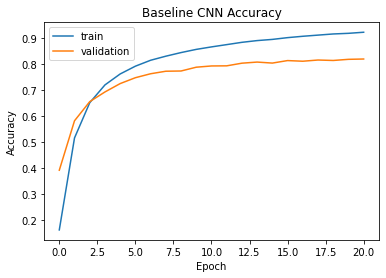

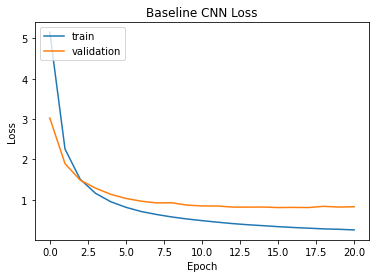

In [54]:
#Show the history of accuracy and loss across epochs.
#Skip this cell if you skipped the previous cell
show_history(history1,'accuracy','Figures/Baseline CNN Accuracy')
show_history(history1,'loss','Figures/Baseline CNN Loss')

We can see from the above graphs that both the training and validation loss and accuracy follow similar trends after crossing over each other at 2 epochs. The validation loss and accuracy however seem to plateau after around 6 epochs and improve much slower than the training loss and accuracy. The gap between the training and validation accuracy could suggest possible over fitting, however it is difficult to interpret without testing the model's performance on the test data.

In the next cell, we will evaluate the model's performance on both the training and test data, and calculate the model's f1-score for its predictions on the test data.

In [51]:
#View the results of the CNN
cnn1_f1 = evaluate_model('Models/Baseline_cnn.h5',x_train,Y_train,x_test,Y_test)
#Save the results
all_models.append('CNN Baseline')
all_models_f1.append(cnn1_f1)


9734/9734 [==============================] - 2s 178us/step

Results

Train loss: 0.76
Train accuracy: 0.82

Test loss: 4.02
Test accuracy: 0.5149989724159241
F1 micro score: 0.5149989726731046


The baseline model achieved 82% accuracy on the training data, with 51% accuracy on the test data, and an f1 micro score of 0.51. The model's f1 and test accuracy scores are roughly the same as the KNN model's performance. The rather large discrepency between the training and test data accuracy suggests that the model may be overfitted.

In our next model architecture, we will try to address this.



<a id = 'second cnn'></a>
### Second CNN model

For our second model, we will try to address the overfitting that we saw in the baseline model. We will try improving the model performance by applying <strong>dropout</strong>.

<strong>Dropout</strong> is a regularisation method for deep learning that is often used to decrease the risk of overfitting to our training data. It is a technique where at every training step, each neuron has a chance of being ignored (or 'dropped out') until the next epoch. In this case we have set the chance of dropout to be 50% and have added a dropout layer after each of the maxpooling layers in our previous model. 

In [52]:
#Build the second CNN architecture
cnn2 = Sequential()
cnn2.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
cnn2.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
cnn2.add(layers.Dropout(rate = .5))
cnn2.add(layers.Conv2D(64, kernel_size=(5, 5), activation='relu'))
cnn2.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
cnn2.add(layers.Dropout(rate = .5))
cnn2.add(layers.Conv2D(128, kernel_size=(7, 7), activation='relu'))
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(64, activation='relu'))
cnn2.add(layers.Dense(num_classes, activation='softmax'))

cnn2.summary()

opt = Adam(learning_rate=0.001)

#Compile the model
cnn2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)        

The summary above shows that our second model is very similar to our baseline model. We still have three convolutional layers with kernel sizes of <i>3x3</i>, <i>5x5</i>, and <i>7x7</i>, with 2 maxpool layers added after the first and second convolutional layers.

However, unlike our first model, we have added a drop out layer after the first two maxpooling layers, and removed the third maxpooling layer. This results in a more complex model with 1,012,217 trainable parameters. The reason for these changes is to address the possible overfitting in our previous model and to add complexity to our model. 

In the next cell we will fit the model to the data, this will take around 30 minutes. As with our baseline model, if you would prefer to load a model that I have previously trained, you can skip to the cell with the command:

            cnn2_f1 = evaluate_model('second_cnn.h5',x_train,Y_train,x_test,Y_test)
        
Please note that if you do decide to train the model, you can view the model's progress as output by setting <i>'verbose = 1'</i> in the cell below. You should also uncomment the line in the next cell to save the new weights.

In [57]:
#Skip this cell if you wish to skip training and load the model

#Train the second CNN. Takes around 20-35 minutes to train
start = time.perf_counter()

history2 = cnn2.fit(x_train_partial, y_train_partial,
          batch_size=128,
          epochs=80,
          verbose=0,
          validation_data=(x_validation, y_validation),
         callbacks =[early_stop])

#Uncomment the next line to overwrite the previously saved model
#cnn2.save('Models/second_cnn.h5')

finish = time.perf_counter()
print(f'Finished training model in {round(finish-start,2)} seconds')

Finished training model in 1074.62 seconds


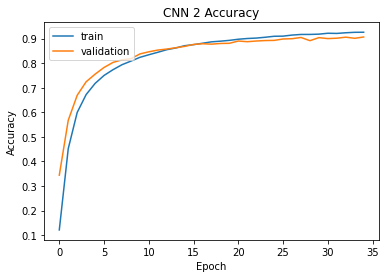

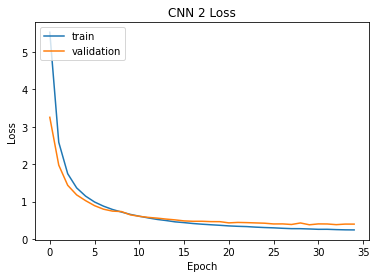

In [58]:
#Show the history of accuracy and loss across epochs.
#Skip this cell if you skipped the previous cell
show_history(history2,'accuracy','Figures/CNN 2 Accuracy')
show_history(history2,'loss','Figures/CNN 2 Loss')

We can see that the second CNN's loss and accuracy for the validation set follow the metrics for the training set very closely. The gap between the validation and training accuracy is very narrow, and in some sections the model actually performs better on the validation set.

This suggests that we have improved the issues with overfitting that we saw in the baseline model. The reason why the model is performing better on the validation set in some parts is due to the dropout layers that we added. While the dropout layers affect the model when it is being trained on the training set and cause the model to drop some of the learned weights to prevent memorisation of the training data and overfitting to it, the dropout layers do not affect the model when it is being validated on the validation data. The model is therefore able to perform at peak performance when it is being validated.

In the next cell, we will see how adding dropout layers has affected the model's performance on the test data.

In [53]:
#View the performance of the second CNN
cnn2_f1 = evaluate_model('Models/second_cnn.h5',x_train,Y_train,x_test,Y_test)
all_models.append('Second CNN')
all_models_f1.append(cnn2_f1)


9734/9734 [==============================] - 2s 166us/step

Results

Train loss: 0.36
Train accuracy: 0.91

Test loss: 2.58
Test accuracy: 0.637867271900177
F1 micro score: 0.637867269365112


We can see that the second CNN model performs much better on the test data. While our KNN model and baseline CNN models achieved 50% and 51% test accuracy respectively, our second CNN model achieved a test accuracy of 63.7% and an f1 micro score of 0.63.

While there is still a rather large discrepency between our training and test accuracy, we were able to improve the model's performance by over 10% in test accuracy and increase the f1-score by 0.1 simply by adding 2 dropout layers. The tradeoff for this improvement in performance however, is that the second CNN model usually takes much longer to train than the first CNN model.

In order to try to achieve better performance, for our next models, we will try implementing more advanced CNN architectures.

<a id = 'inception'></a>
### Inception Modules

For our next model we will try to expand our CNN by implementing <strong>Inception Modules</strong>. Inception modules were first introduced by Szegedy et al (2015) from Google Research. The authors used these modules to develop CNNs much deeper than had previously been possible. Choosing an appropriate kernel size for convolutional layers can be difficult due to finding a balance between targeting localized information in an image and general high-level information. Stacking too many convolutional layers can result in a drop in performance due to issues such as vanishing gradients (explained [below](#resnet)). 

Inception modules were introduced by Szegedy et al (2015) as a solution to this by implementing multiple convolutional layers in parallel rather than in sequence. By implementing an Inception module, a CNN can process images through <i>1x1</i>, <i>3x3</i>. and <i>5x5</i> all within a single unit and capture more complex patterns in images at different scales, as well as reduce dimensionality, cutting down on computation costs (Geron, 2019)

Below is a diagram expaining the structure of an inception module (adapted from Geron, 2019):

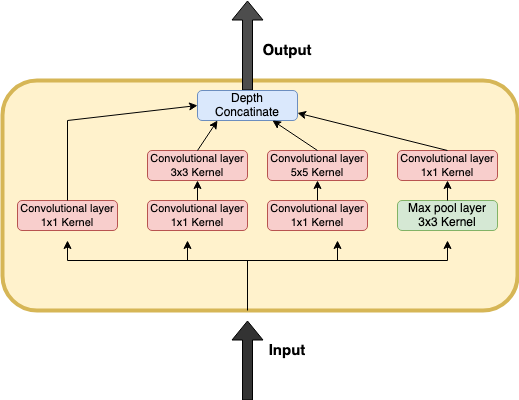

Although we will not be implementing the full GoogleNet architecture which the inception modules were initially used for, I have created a class implementation for the Inception module (the details are in the 'deep_learning_tools.py' file) which we can use to see if we can improve the performance further. We can add InceptionModules to our CNN just like normal layers.

We will first try building a model with a single inception module and then build two additional models, increasing the number of inception modules each time.

<a id = 'single_incep'></a>
### Adding a Single Inception module

Firstly, we will try implementing a single Inception module within the second CNN model we built. We will also make a few small changes to the architecture of our second model. 

Firstly, we have given our initial convolutional layer a larger kernel size. The reason for this is to preserve the image's information as it is passed into the inception module, as the inception module will decrease the dimensionality of the image further.

We have also removed a dropout layer and just included one at the end of the network, and we have also applied a GlobalAvg2D layer after the inception module instead of a Flatten layer. This is based on the GoogleNet architecture in which the inception modules were famously used. 

Finally we have also implemented a new 'layer' called <i>Local Response Normalization</i>. Local Response Normalization is a <i>competitive</i> normalization step which was also used in the GoogleNet architecture. It works by making the most strongly activated neurons in one feature map inhibit the response of other neurons located in the same position in neighbouring feature maps (Geron, 2019 p.465). The reason for using local response normalization is to encourage feature maps to specialize on specific regions and for other feature maps to find other regions to specialize on. 

As keras does not have a layer for local response normalization, I have written a custom class that uses TensorFlow's implementation of local response normalization as a Keras Layer. The details can be found in the <i>'deep_learning_tools.py'</i> file.

In [54]:
#Build the Inception model architecture
inception_mod1 = Sequential()
inception_mod1.add(layers.Conv2D(64, kernel_size=(7, 7), strides=1, activation='relu',input_shape=input_shape))
inception_mod1.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
inception_mod1.add(LocalResponseNormalization())
inception_mod1.add(layers.Conv2D(64, kernel_size=(1, 1),strides=1, activation='relu'))
inception_mod1.add(layers.Conv2D(288, kernel_size=(3, 3),strides=1, activation='relu'))
inception_mod1.add(LocalResponseNormalization())
inception_mod1.add(layers.MaxPooling2D(pool_size=(3, 3),strides=1))
inception_mod1.add(InceptionModule([64,96,128,32,64,32]))
inception_mod1.add(layers.GlobalAvgPool2D())
inception_mod1.add(layers.Dropout(rate=0.4))
inception_mod1.add(layers.Dense(num_classes, activation='softmax'))


opt = Adam(learning_rate=0.001)

#Compile the model
inception_mod1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

The above cell describes the architecture of the inception module model. You can see that I have specified the number of filters for the inception module as: 64,96,128,32,64,32.

This diagram shows which layers each number of filters will be assigned to:

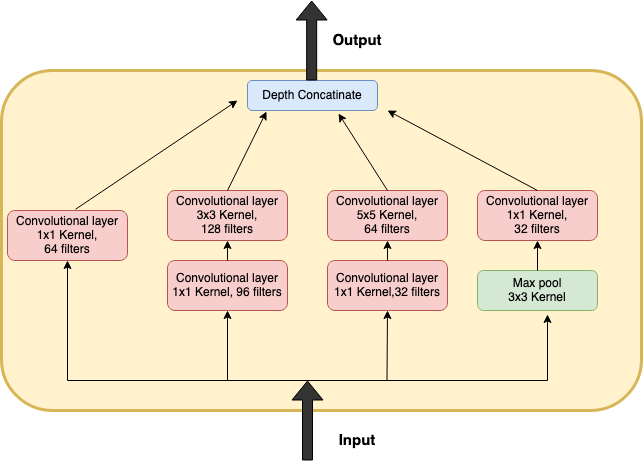


When specifiying the number of filters, we need to make sure that the output adds up to the number of filters of our previous convolutional layer. In this case, our previous convolutional layer has 288 filters. We can check if the number of filters is valid by adding the number of filters in our final four layers: 64 + 128 + 64 + 32 = 288

When specifying the numbers of filters, the general idea is to set it so the first layers have less filters than the second layers, this is because the idea of the inception module is that the earlier layers with kernels of <i>1x1</i> work as a way to reduce the dimensionality of the feature maps so that the layers with larger kernel sizes have less computational cost.

In [55]:
inception_mod1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 58, 58, 64)        3200      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
local_response_normalization (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 64)        4160      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 288)       166176    
_________________________________________________________________
local_response_normalization (None, 27, 27, 288)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 288)      

Above is a summary of our model including the Inception module. In the next cell we will train our first inception module model. The time that it takes can vary and sometimes may take up to 50 minutes. However, if you would like to skip the training, you can skip the next two cells and go directly to the cell with the code:

    inception_mod1_f1 = evaluate_model('Inception_model1.h5',x_train,Y_train,x_test,Y_test)
            
Please note that if you do decide to train the model, you can view the model's progress as output by setting <i>'verbose = 1'</i> in the cell below. You should also uncomment the line in the next cell to save the new weights.

In [62]:
#Skip this cell if you would like to skip the training

#Train the model with one Inception module.

start = time.perf_counter()

history3 = inception_mod1.fit(x_train_partial, y_train_partial,
          batch_size=128,
          epochs=60,
          verbose=0,
          validation_data=(x_validation, y_validation),
         callbacks =[early_stop])

#Uncomment the next line to overwrite the previously saved model
#inception_mod1.save('Models/Inception_model1.h5')

finish = time.perf_counter()
print(f'Finished training model in {round(finish-start,2)} seconds')

Finished training model in 3378.4 seconds


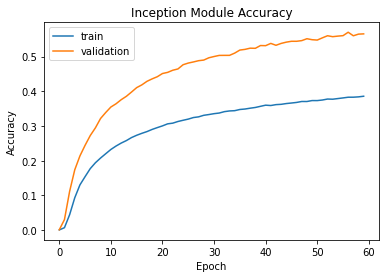

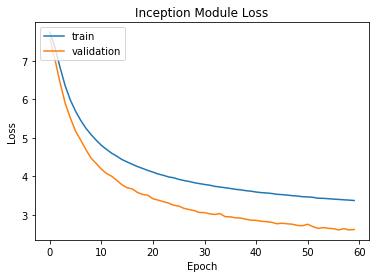

In [63]:
#Show the history of accuracy and loss across epochs.
#Skip this cell if you skipped the previous cell
show_history(history3,'accuracy','Figures/Inception Module Accuracy')
show_history(history3,'loss','Figures/Inception Module Loss')

Note that we are using custom layers for the Inception model. If we are using pretrained weights, we will need to build the architecture and load the trained weights seperately instead of just loading the full model (as we did with the previous models). However, since we defined the architecture and compiled the model in a previous cell, we can simply load the trained weights into that model.

In [56]:
#Reload trained weights into model Architecture
inception_mod1.load_weights('Models/Inception_model1.h5')
print("Loaded trained weights from disk")

#View performance of the model
inception_mod1_f1 = evaluate_model(inception_mod1,x_train,Y_train,x_test,Y_test)

#Store results of model
all_models.append('Inception Model')
all_models_f1.append(inception_mod1_f1)


Loaded trained weights from disk
9734/9734 [==============================] - 2s 247us/step

Results

Train loss: 27.59
Train accuracy: 0.0

Test loss: 25.04
Test accuracy: 0.000616396137047559
F1 micro score: 0.0006163961372508733


We can see an interesting trend in the results of the Inception Module model. When we observe the accuracy of the validation and training sets across the epochs, the validation consistently scores higher, by a fairly wide margin. The results of the second CNN model also had parts where the model performed better on the validation set, but for the second CNN, the results converged and were quite close to each other in performance. A possible explanation for this is that when applying dropout with the inception module, the amount layers in the inception module amplify the effect of dropout on the training data.

In terms of performance, the model was a poor fit for the data in terms of both accuracy and F1 micro score. In the next few models we will experiment with adding more inception modules.

<a id = 'additional_inceps'></a>
### Implementing additional Inception Modules

Overall we saw a pretty large drop in performance from adding the Inception module. We will try to see if adding additional modules helps improve the performance. For our next two model architectures, we will try with two and three Inception modules respectively. We will build and train them both in the next few cells.

In [57]:
#Build second model with two Inception modules
inception_mod2 = Sequential()
inception_mod2.add(layers.Conv2D(64, kernel_size=(7, 7), strides=1, activation='relu',input_shape=input_shape))
inception_mod2.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
inception_mod2.add(LocalResponseNormalization())
inception_mod2.add(layers.Conv2D(64, kernel_size=(1, 1),strides=1, activation='relu'))
inception_mod2.add(layers.Conv2D(288, kernel_size=(3, 3),strides=1, activation='relu'))
inception_mod2.add(LocalResponseNormalization())
inception_mod2.add(layers.MaxPooling2D(pool_size=(3, 3),strides=1))
inception_mod2.add(InceptionModule([64,96,128,32,64,32]))
inception_mod2.add(InceptionModule([32,96,64,64,160,32]))
inception_mod2.add(layers.GlobalAvgPool2D())
inception_mod2.add(layers.Dropout(rate=0.4))
inception_mod2.add(layers.Dense(num_classes, activation='softmax'))

opt = Adam(learning_rate=0.001)

#Compile model
inception_mod2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [58]:
#Build third Inception model with 3 modules
inception_mod3 = Sequential()
inception_mod3.add(layers.Conv2D(64, kernel_size=(7, 7), strides=1, activation='relu',input_shape=input_shape))
inception_mod3.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
inception_mod3.add(LocalResponseNormalization())
inception_mod3.add(layers.Conv2D(64, kernel_size=(1, 1),strides=1, activation='relu'))
inception_mod3.add(layers.Conv2D(288, kernel_size=(3, 3),strides=1, activation='relu'))
inception_mod3.add(LocalResponseNormalization())
inception_mod3.add(layers.MaxPooling2D(pool_size=(3, 3),strides=1))
inception_mod3.add(InceptionModule([64,96,128,32,64,32]))
inception_mod3.add(InceptionModule([32,96,64,64,160,32]))
inception_mod3.add(InceptionModule([16,96,128,96,128,16]))
inception_mod3.add(layers.GlobalAvgPool2D())
inception_mod3.add(layers.Dropout(rate=0.4))
inception_mod3.add(layers.Dense(num_classes, activation='softmax'))

opt = Adam(learning_rate=0.001)

#Compile model
inception_mod3.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

We will train both models in the next cell and examine the results at the same time. Training time can vary from around 10 minutes to 40 minutes per model.

If you would prefer to skip the training and load the previously trained models you can do by skipping the next two cells. To the cell with the comment:

    #View performance with 2 inception modules

Please note that if you do decide to train the models, you can view their progress as output by setting <i>'verbose = 1'</i> in the cell below. You should also uncomment the lines in the next cell to save the new weights.

In [68]:
#Skip this cell if you would like to skip the training

#Train the Inception model with 2 modules

#Takes around 10 minutes to train with 2 modules
start = time.perf_counter()

history4 = inception_mod2.fit(x_train_partial, y_train_partial,
          batch_size=128,
          epochs=40,
          verbose=0,
          validation_data=(x_validation, y_validation),
         callbacks =[early_stop])

#Uncomment the next line to overwrite the previously saved model
#inception_mod2.save('Models/Inception_model2.h5')

finish = time.perf_counter()
print(f'Finished training model with 2 inception modules in {round(finish-start,2)} seconds')

#Train the Inception model with 3 modules. Takes around 10 minutes.
start = time.perf_counter()

history5 = inception_mod3.fit(x_train_partial, y_train_partial,
          batch_size=128,
          epochs=40,
          verbose=0,
          validation_data=(x_validation, y_validation),
         callbacks =[early_stop])

#Uncomment the next line to overwrite the previously saved model
#inception_mod3.save('Models/Inception_model3.h5')

finish = time.perf_counter()
print(f'Finished training model with 3 inception modules in {round(finish-start,2)} seconds')

Finished training model with 2 inception modules in 2937.13 seconds
Finished training model with 3 inception modules in 3601.35 seconds


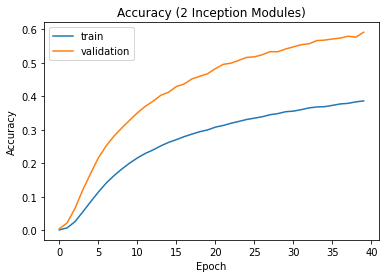

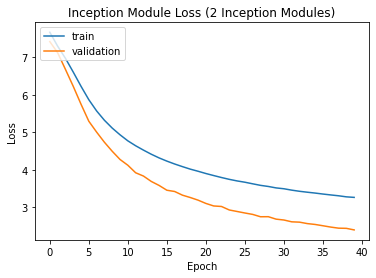

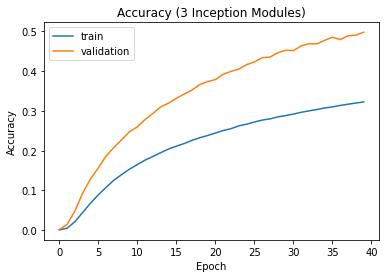

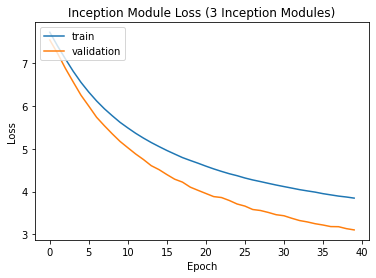

In [69]:
#Show the history of accuracy and loss across epochs.
#Skip this cell if you skipped the previous cell
show_history(history4,'accuracy','Figures/Accuracy (2 Inception Modules)')
show_history(history4,'loss','Figures/Inception Module Loss (2 Inception Modules)')

show_history(history5,'accuracy','Figures/Accuracy (3 Inception Modules)')
show_history(history5,'loss','Figures/Inception Module Loss (3 Inception Modules)')

In [59]:
#View performance with 2 inception modules


#Reload trained weights into model Architecture
inception_mod2.load_weights('Models/Inception_model2.h5')
print("Loaded trained weights from disk")

#View performance of the model
inception_mod2_f1 = evaluate_model(inception_mod2,x_train,Y_train,x_test,Y_test)
all_models.append('Inception Model 2')
all_models_f1.append(inception_mod2_f1)


#View performance with 3 inception modules
print('\n')

#Reload trained weights into model Architecture
inception_mod3.load_weights('Models/Inception_model3.h5')
print("Loaded trained weights from disk")

#View performance of the model
inception_mod3_f1 = evaluate_model(inception_mod3,x_train,Y_train,x_test,Y_test)
all_models.append('Inception Model 3')
all_models_f1.append(inception_mod3_f1)

Loaded trained weights from disk
9734/9734 [==============================] - 3s 306us/step

Results

Train loss: 75.23
Train accuracy: 0.0

Test loss: 67.46
Test accuracy: 0.0002054653741652146
F1 micro score: 0.0002054653790836244


Loaded trained weights from disk
9734/9734 [==============================] - 3s 350us/step

Results

Train loss: 93.32
Train accuracy: 0.0

Test loss: 85.96
Test accuracy: 0.0002054653741652146
F1 micro score: 0.0002054653790836244


We can see from the results that adding additional inception modules did not improve the overall model's performance and the CNN architectures incooporating Inception modules are not particularly effective. At this time, our best performing model is still the second CNN with dropout applied.

<a id = 'resnet'></a>
## ResNet CNN Architechture

We will now try to implement a ResNet (residual network) CNN architecture to classify our data. ResNet architectures were used by Kaiming He et al (2015) to win The ImageNet Large Scale Visual Recognition Challenge (ILSVRC), and have since become a popular CNN architecture for the purpose of image recognition. Residual Networks make use of <strong>residual units</strong> and allow us to build very deep and complex neural networks. 

To understand how residual units help, we need to understand the <i>vanishing gradient problem</i>. Neural networks are trained through back propagation by calculating the gradients at the end of the network. The gradients are used to adjust the weights of each layer from the last to the first. However as we add additional layers to our network, and the gradients are repeatedly multiplied by the weights as they are back propogated, the values of the gradients can decrease to a point where they can no longer meaningfully adjust the weights at the ealier layers of the model. This is known as the <i>vanishing gradient problem</i>.

Residual units, help us overcome the vanishing gradient problem by providing a shortcut which allows the model to bypass several convolutional layers and preserve the original signal of the image. This shortcut allows us to add more layers to our models without diluting the gradients. Residual Units can be included in a CNN much like a regular layer. Here is a diagram demonstrating how they might be used:

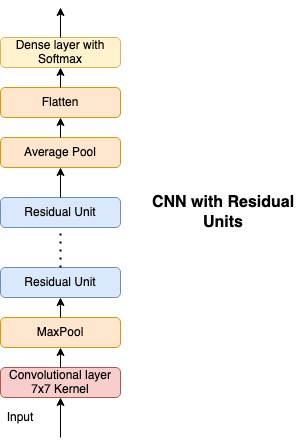

We will experiment with two ResNet architectures, the ResNet34 and the ResNet50. The ResNet34 has a total of 34 layers (only counting convolutional layers and fully connected layers), and the ResNet50 has 50. I have included a custom class for implementing a residual unit from Geron's <i>Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow</i> (2019, p.478). I have also adapted Geron's code to create another class for a ResNet50 residual unit (which has a slightly different architecture). The classes can both be found in a seperate file called <i>'deep_learning_tools.py'</i>

___


<a id = 'resnet34'></a>
## ResNet34

In our ResNet34 architecture. We will use an initial convolutional layer followed by batch normalisation and maxpooling. We will then include 16 residual units, where each residual unit will consist of two main convolutional layers and a <i>shortcut path</i>. The two main convolutional layers will each have kernel sizes of 3, and the shortcut path will have a kernel size of 1. By setting the shortcut's kernel size to 1, the shape of the image is preserved as it passes through. The input that has processed through the main path and the shortcut path are then summed and passed through a Relu activation function.

The filter size for each of the residual units will be:

- 3 units with filter sizes of 64
- 4 units with filter sizes of 128
- 6 units with filter sizes of 256
- 3 units with filter sizes of 512

Here is a diagram of the structure of a residual unit in the ResNet34:

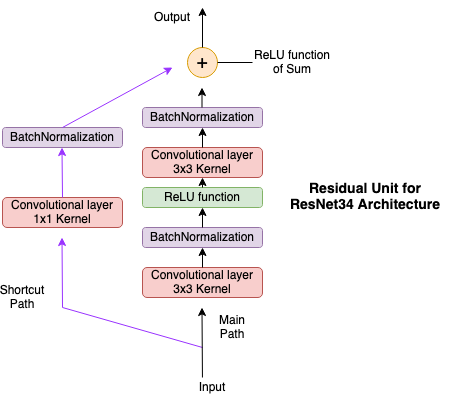


We will implement the model in the following cell.


In [60]:
#Build a ResNet34 CNN model
resNet_34 = Sequential()
resNet_34.add(layers.Conv2D(64,7,strides=2,input_shape = input_shape,padding="same",use_bias=False))
resNet_34.add(layers.BatchNormalization())
resNet_34.add(layers.Activation('relu'))
resNet_34.add(layers.MaxPool2D(pool_size=3,strides=2,padding="same"))
prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256]*6 + [512]*3:
    if prev_filters == filters:
        strides = 1
    else: 
        strides = 2
    #Add 3 Units with 64 filters, 4 with 128, 6 with 256 and 3 with 512
    resNet_34.add(ResidualUnit34(filters,strides=strides))
    prev_filters = filters

resNet_34.add(layers.AveragePooling2D((2, 2), name='avg_pool'))
resNet_34.add(layers.Flatten())
resNet_34.add(layers.Dense(num_classes,activation = "softmax"))

#Specify the optimizing algorithm and compile the model
opt = Adam(learning_rate=0.001)

resNet_34.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

We will now fit the ResNet34 to the data. This will take around 10 minutes to train.

If you would prefer to skip the training you can skip the next two cells to the cell with the code:

            resnet34_f1 = evaluate_model('ResNet34.h5',x_train,Y_train,x_test,Y_test)
            
Please note that if you do decide to train the model, you can view the model's progress as output by setting <i>'verbose = 1'</i> in the cell below. You should also uncomment the line in the next cell to save the new weights.

In [82]:
#Skip this cell if you would like to skip the training

#Train the ResNet34 model. Takes around 10 minutes to train
start = time.perf_counter()

history6 = resNet_34.fit(x_train_partial, y_train_partial,
          batch_size=128,
          epochs=100,
          verbose=0,
          validation_data=(x_validation, y_validation),
         callbacks =[early_stop])

#Uncomment the next line to overwrite the previously saved model
#resNet_34.save('Models/ResNet34.h5')

finish = time.perf_counter()
print(f'Finished training model in {round(finish-start,2)} seconds')

Finished training model in 442.34 seconds


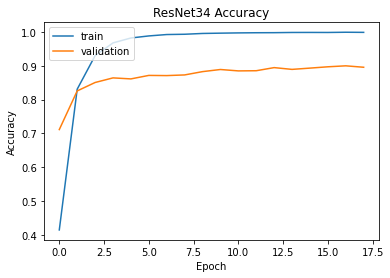

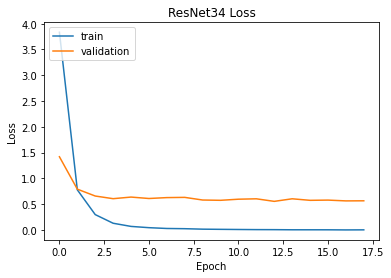

In [83]:
#Show the history of accuracy and loss across epochs.
#Skip this cell if you skipped the previous cell
show_history(history6,'accuracy','Figures/ResNet34 Accuracy')
show_history(history6,'loss','Figures/ResNet34 Loss')

In [61]:
#Load pretrained weights
resNet_34.load_weights('Models/ResNet34.h5')
print("Loaded trained weights from disk")

#View performance of the model
resnet34_f1 = evaluate_model(resNet_34,x_train,Y_train,x_test,Y_test)
all_models.append('ResNet34')
all_models_f1.append(resnet34_f1)

Loaded trained weights from disk
9734/9734 [==============================] - 2s 180us/step

Results

Train loss: 0.53
Train accuracy: 0.9

Test loss: 2.64
Test accuracy: 0.6535853743553162
F1 micro score: 0.6535853708650092


The ResNet34 is our best performing model so far with test accuracy of 65% and an F1 micro score of 0.65. The ResNet34 model also typically takes less time to train than the second CNN model as well. 

<a id = 'res34_dropout'></a>
### ResNet34 with Dropout

We saw that we were able to improve our baseline CNN's performance by applying dropout layers, so for our next model architectures we will try applying dropout to our ResNet34 model. We will experiment with two drop out architectures.

1. For our first architecture, we will only add a single drop out layer, and we will add it after our residual units.

2. For our second architecture, we will add two drop out layers, one before the residual units, and one after our residual units.



### 1st ResNet34 with Dropout:

Here we have added a single dropout layer after our residual units.

In [62]:
#Build a ResNet34 CNN model with a single dropout layer
resNet_34_drop1 = Sequential()
resNet_34_drop1.add(layers.Conv2D(64,7,strides=2,input_shape = input_shape,padding="same",use_bias=False))
resNet_34_drop1.add(layers.BatchNormalization())
resNet_34_drop1.add(layers.Activation('relu'))
resNet_34_drop1.add(layers.MaxPool2D(pool_size=3,strides=2,padding="same"))
prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256]*6 + [512]*3:
    if prev_filters == filters:
        strides = 1
    else: 
        strides = 2
    #Add 3 Units with 64 filters, 4 with 128, 6 with 256 and 3 with 512
    resNet_34_drop1.add(ResidualUnit34(filters,strides=strides))
    prev_filters = filters

#Add single dropout layer
resNet_34_drop1.add(layers.Dropout(rate=0.5))
resNet_34_drop1.add(layers.AveragePooling2D((2, 2), name='avg_pool'))
resNet_34_drop1.add(layers.Flatten())
resNet_34_drop1.add(layers.Dense(num_classes,activation = "softmax"))

opt = Adam(learning_rate=0.001)

#Compile model
resNet_34_drop1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### 2nd ResNet34 with dropout

Here we will build the second ResNet model with dropout.

In [63]:
#Build second ResNet34 model with 2 dropout layers
resNet_34_drop2 = Sequential()
resNet_34_drop2.add(layers.Conv2D(64,7,strides=2,input_shape = input_shape,padding="same",use_bias=False))
resNet_34_drop2.add(layers.BatchNormalization())
resNet_34_drop2.add(layers.Activation('relu'))
resNet_34_drop2.add(layers.MaxPool2D(pool_size=3,strides=2,padding="same"))
#Add first dropout layer
resNet_34_drop2.add(layers.Dropout(rate=0.5))

prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256]*6 + [512]*3:
    if prev_filters == filters:
        strides = 1
    else: 
        strides = 2
    #Add 3 Units with 64 filters, 4 with 128, 6 with 256 and 3 with 512
    resNet_34_drop2.add(ResidualUnit34(filters,strides=strides))
    prev_filters = filters

#Add second dropout layer
resNet_34_drop2.add(layers.Dropout(rate=0.5))
resNet_34_drop2.add(layers.AveragePooling2D((2, 2), name='avg_pool'))
resNet_34_drop2.add(layers.Flatten())
resNet_34_drop2.add(layers.Dense(num_classes,activation = "softmax"))

opt = Adam(learning_rate=0.001)

#Compile model
resNet_34_drop2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

We will run both architectures in the following cells and examine the results afterwards. 

If you would prefer to skip the training (around 20-30 minutes in total), skip the next two cells and go directly to the cell with the code:

    #Evaluate the results of the first ResNet34 with Dropout
    resNet34_drop1_f1 = evaluate_model('ResNet34Dropout1.h5',x_train,Y_train,x_test,Y_test)
        
            
Please note that if you do decide to train the models, you can view their progress as output by setting <i>'verbose = 1'</i> in the cell below. You should also uncomment the lines in the next cell to save the new weights.

In [87]:
#Skip this cell if you would like to skip training
#Train the ResNet34 models with Dropout. 
#Takes around 10-15 minutes per model to train

start = time.perf_counter()

history7 = resNet_34_drop1.fit(x_train_partial, y_train_partial,
          batch_size=128,
          epochs=100,
          verbose=0,
          validation_data=(x_validation, y_validation),
         callbacks =[early_stop])

#Uncomment the next line to overwrite the pretrained model
#resNet_34_drop1.save('Models/ResNet34Dropout1.h5')

finish = time.perf_counter()
print(f'Finished training first model in {round(finish-start,2)} seconds')


#Train the second resNet34 model with dropout. 
#Takes around 10-15 minutes to train
start = time.perf_counter()

history8 = resNet_34_drop2.fit(x_train_partial, y_train_partial,
          batch_size=128,
          epochs=100,
          verbose=0,
          validation_data=(x_validation, y_validation),
         callbacks =[early_stop])

#Uncomment the next line to overwrite the pretrained model
#resNet_34_drop2.save('Models/ResNet34Dropout2.h5')

finish = time.perf_counter()
print(f'Finished training second model in {round(finish-start,2)} seconds')

Finished training model in 377.03 seconds
Finished training model in 503.23 seconds


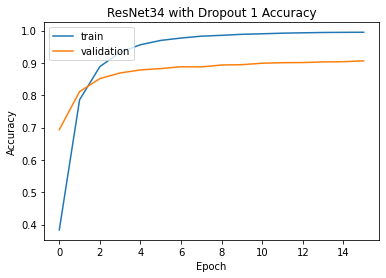

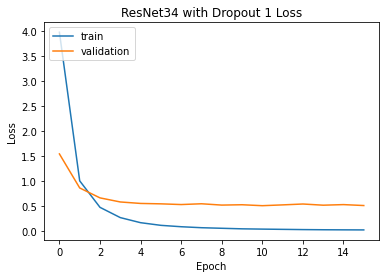

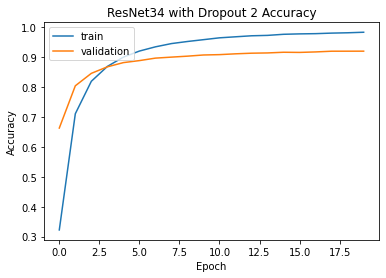

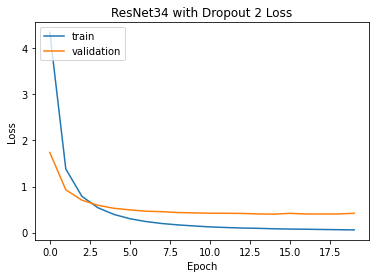

In [88]:
#Show the history of accuracy and loss across epochs.
#Skip this cell if you skipped the previous cell
show_history(history7,'accuracy','Figures/ResNet34 with Dropout 1 Accuracy')
show_history(history7,'loss','Figures/ResNet34 with Dropout 1 Loss')

#View the Results of the second ResNet34 model with Dropout
show_history(history8,'accuracy','Figures/ResNet34 with Dropout 2 Accuracy')
show_history(history8,'loss','Figures/ResNet34 with Dropout 2 Loss')

In [64]:
#Load pretrained weights for the first dropout model
resNet_34_drop1.load_weights('Models/ResNet34Dropout1.h5')
print("Loaded trained weights from disk")

#View performance of the first dropout model
resNet34_drop1_f1 = evaluate_model(resNet_34_drop1,x_train,Y_train,x_test,Y_test)
all_models.append('ResNet34 With Dropout 1')
all_models_f1.append(resNet34_drop1_f1)


Loaded trained weights from disk
9734/9734 [==============================] - 2s 174us/step

Results

Train loss: 0.48
Train accuracy: 0.9

Test loss: 2.47
Test accuracy: 0.6522498726844788
F1 micro score: 0.6522498459009657


In [65]:
#Load pretrained weights for the second dropout model
resNet_34_drop2.load_weights('Models/ResNet34Dropout2.h5')
print("Loaded trained weights from disk")

#View performance of the second dropout model
resNet34drop2_f1 = evaluate_model(resNet_34_drop2,x_train,Y_train,x_test,Y_test)
all_models.append('ResNet34 With Dropout 2')
all_models_f1.append(resNet34drop2_f1)

Loaded trained weights from disk
9734/9734 [==============================] - 2s 193us/step

Results

Train loss: 0.38
Train accuracy: 0.92

Test loss: 2.2
Test accuracy: 0.6895418167114258
F1 micro score: 0.6895418122046435


We can see that both of the ResNet34 dropout architectures performed better than the regular ResNet34 architecture, with the second dropout architecture being the best performing model so far (with a test accuracy of approximately 68.9% and an f1-micro score of 0.689).

<a id = 'resnet50'></a>
## ResNet50

We will now experiment with the ResNet50 CNN architecture. This architecture includes 16 residual units each with 3 convolutional layers in the main path and one in the shortcut path.

Like the ResNet34, the shortcut path only consists of a single convolutional layer with a kernel size of one. In the main path, the filter and kernel size for each unit will be:

- 3 units with 2 convolutional layers of 64 filters (one with a kernel size of 3 and one with a kernel size of 1) and another convolutional layer with 256 filters (kernel size 1). 
- 4 units with 2 convolutional layers of 128 filters (one with a kernel size of 3 and one with a kernel size of 1) and another convolutional layer with 512 filters (kernel size 1). 
- 6 units with 2 convolutional layers of 256 filters (one with a kernel size of 3 and one with a kernel size of 1) and another convolutional layer with 1024 filters (kernel size 1). 
- 3 units with 2 convolutional layers of 512 filters (one with a kernel size of 3 and one with a kernel size of 1) and another convolutional layer with 2048 filters (kernel size 1).

Here is a diagram showing the structure of a residual unit in the ResNet50 architecture:

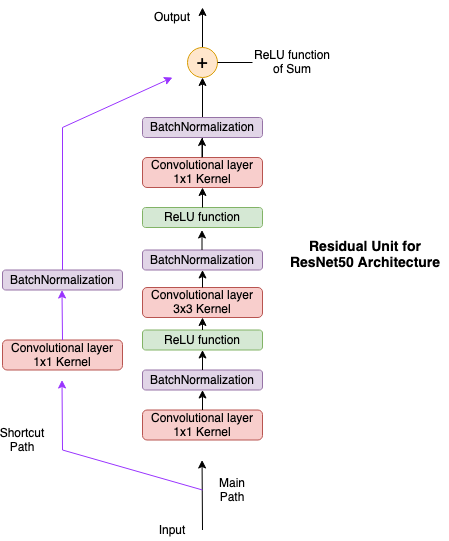

In the next cell we will implement the architecture for a ResNet50 model in code:

In [66]:
#Build a ResNet50 CNN model
resNet_50 = Sequential()
resNet_50.add(layers.Conv2D(64,7,strides=2,input_shape = input_shape,padding="same",use_bias=False))
resNet_50.add(layers.BatchNormalization())
resNet_50.add(layers.Activation('relu'))
resNet_50.add(layers.MaxPool2D(pool_size=3,strides=2,padding="same"))

prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256]*6 + [512]*3:
    if prev_filters == filters:
        strides = 1
    else: 
        strides = 2
    #Add 3 Units with 64 filters, 4 with 128, 6 with 256 and 3 with 512
    resNet_50.add(ResidualUnit50(filters,strides=strides))
    prev_filters = filters

resNet_50.add(layers.AveragePooling2D((2, 2), name='avg_pool'))
resNet_50.add(layers.Flatten())
resNet_50.add(layers.Dense(num_classes,activation = "softmax"))

#Compile model
opt = Adam(learning_rate=0.001)

resNet_50.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Now that we have defined the Resnet50 architecture, we will fit it to the data in the next cell. If you would like to skip this, you can skip the next two cells and go directly to the cell with the code:

    resNet_50_f1 = evaluate_model('ResNet50.h5',x_train,Y_train,x_test,Y_test)

The model will take approximately 10 minutes to train. Please note that if you do decide to train the model, you can view the model's progress as output by setting <i>'verbose = 1'</i> in the cell below. You should also uncomment the line in the next cell to save the new weights.

In [92]:
#Skip this cell if you would like to skip the training
#Train the resNet50 model. Takes around 10 minutes to train

start = time.perf_counter()

history9 = resNet_50.fit(x_train_partial, y_train_partial,
          batch_size=128,
          epochs=100,
          verbose=0,
          validation_data=(x_validation, y_validation),
         callbacks =[early_stop])

#Uncomment the next line to overwrite the pretrained model
#resNet_50.save('Models/ResNet50.h5')

finish = time.perf_counter()
print(f'Finished training model in {round(finish-start,2)} seconds')

Finished training model in 307.35 seconds


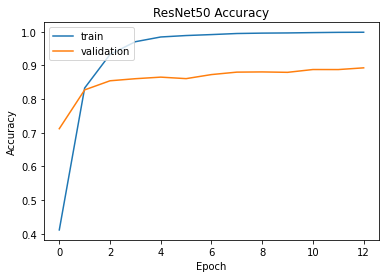

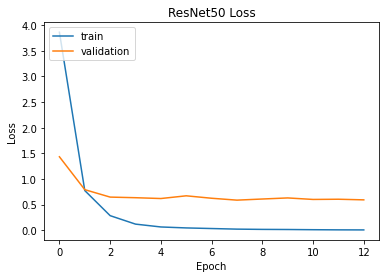

In [93]:
#Show the history of accuracy and loss across epochs.
#Skip this cell if you skipped the previous cell
show_history(history9,'accuracy','Figures/ResNet50 Accuracy')
show_history(history9,'loss','Figures/ResNet50 Loss')

In [67]:
#Load pretrained weights
resNet_50.load_weights('Models/ResNet50.h5')
print("Loaded trained weights from disk")

#View performance of the model
resNet_50_f1 = evaluate_model(resNet_50,x_train,Y_train,x_test,Y_test)
all_models.append('ResNet50')
all_models_f1.append(resNet_50_f1)

Loaded trained weights from disk
9734/9734 [==============================] - 2s 179us/step

Results

Train loss: 0.55
Train accuracy: 0.89

Test loss: 2.49
Test accuracy: 0.6365317702293396
F1 micro score: 0.6365317444010684


Overall we can see that the model is performing about as well as the ResNet34 model with a single dropout layer. We can see in the Accuracy and Loss plots that there is a fairly wide gap between the training and validation sets, suggesting possible overfitting. For our next architectures we will experiment by adding dropout layers.

<a id = 'resnet50do'></a>
## ResNet50 with Dropout

As we have seen with our second CNN model, and the ResNet34 models, applying dropout can help address overfitting and improve overall model performance. We will therefore try experimenting with applying drop out layers to our ResNet50 model to see if we can further improve the performance.

We will experiment with the same two architectures that we used with the ResNet34 model i.e., for our first architecture, we will try adding a single dropout after the residual units, and for our second model architecture, we try adding two dropout layers; one before the residual units, and one after the residual units.

### Defining the first model architecture (Single dropout layer)

In [68]:
#Define the first model
resNet_50_drop1 = Sequential()
resNet_50_drop1.add(layers.Conv2D(64,7,strides=2,input_shape = input_shape,padding="same",use_bias=False))
resNet_50_drop1.add(layers.BatchNormalization())
resNet_50_drop1.add(layers.Activation('relu'))
resNet_50_drop1.add(layers.MaxPool2D(pool_size=3,strides=2,padding="same"))

prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256]*6 + [512]*3:
    if prev_filters == filters:
        strides = 1
    else: 
        strides = 2
    resNet_50_drop1.add(ResidualUnit50(filters,strides=strides))
    prev_filters = filters

#Add a single dropout layer
resNet_50_drop1.add(layers.Dropout(rate=0.5))

resNet_50_drop1.add(layers.AveragePooling2D((2, 2), name='avg_pool'))
resNet_50_drop1.add(layers.Flatten())
resNet_50_drop1.add(layers.Dense(num_classes,activation = "softmax"))

opt = Adam(learning_rate=0.001)

#Compile the model
resNet_50_drop1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In the next cell we will fit the model to the data (this usually takes around 8 minutes). To skip this, you can skip directly to the cell with the code:

    resNet_50_drop1_f1 = evaluate_model('ResNet50_Dropout1.h5',x_train,Y_train,x_test,Y_test)

Please note that if you do decide to train the model, you can view the model's progress as output by setting <i>'verbose = 1'</i> in the cell below. You should also uncomment the line in the next cell to save the new weights.

In [96]:
#Skip this cell if you would like to skip the training
#This cell will train the first dropout model.

#Takes around 8 minutes to train
start = time.perf_counter()

history10 = resNet_50_drop1.fit(x_train_partial, y_train_partial,
          batch_size=128,
          epochs=100,
          verbose=0,
          validation_data=(x_validation, y_validation),
         callbacks =[early_stop])

#Uncomment the next line to overwrite the pretrained model
#resNet_50_drop1.save('Models/ResNet50_Dropout1.h5')

finish = time.perf_counter()
print(f'Finished training model in {round(finish-start,2)} seconds')

Finished training model in 441.35 seconds


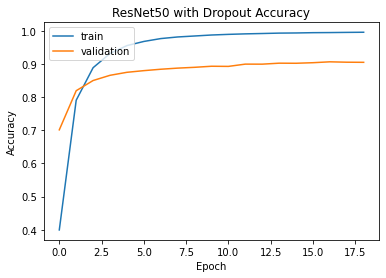

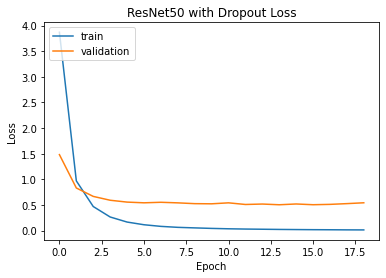

In [97]:
#Show the history of accuracy and loss across epochs.
#Skip this cell if you skipped the previous cell
show_history(history10,'accuracy','Figures/ResNet50 with Dropout Accuracy')
show_history(history10,'loss','Figures/ResNet50 with Dropout Loss')

In [69]:
#Load pretrained weights
resNet_50_drop1.load_weights('Models/ResNet50_Dropout1.h5')
print("Loaded trained weights from disk")

#View performance of the model
resNet_50_drop1_f1 = evaluate_model(resNet_50_drop1,x_train,Y_train,x_test,Y_test)
all_models.append('ResNet50 with Dropout 1')
all_models_f1.append(resNet_50_drop1_f1)

Loaded trained weights from disk
9734/9734 [==============================] - 2s 182us/step

Results

Train loss: 0.48
Train accuracy: 0.91

Test loss: 2.61
Test accuracy: 0.6661187410354614
F1 micro score: 0.6661187589891103


Interestingly, our first ResNet50 architecture with dropout has not improved the performance significantly. While the model without dropout achieved an f1 score of 0.636, applying a single dropout layer improved the f1 score very slightly to 0.666. We can also see that there is still a gap between the training and validation sets in the accuracy and loss plots, suggesting that there may still be some overfitting despite applying dropout.

## ResNet50 Second model with dropout

We will now try implementing a ResNet50 model with two dropout layers in the following cell. The first will be directly before the residual filters and the second will be after them.



In [70]:
#Build the model
resNet_50_drop2 = Sequential()
resNet_50_drop2.add(layers.Conv2D(64,7,strides=2,input_shape = input_shape,padding="same",use_bias=False))
resNet_50_drop2.add(layers.BatchNormalization())
resNet_50_drop2.add(layers.Activation('relu'))
resNet_50_drop2.add(layers.MaxPool2D(pool_size=3,strides=2,padding="same"))
#Apply the first dropout layer
resNet_50_drop2.add(layers.Dropout(rate=0.5))

prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256]*6 + [512]*3:
    if prev_filters == filters:
        strides = 1
    else: 
        strides = 2
    resNet_50_drop2.add(ResidualUnit50(filters,strides=strides))
    prev_filters = filters

#Apply the second dropout layer
resNet_50_drop2.add(layers.Dropout(rate=0.5))
resNet_50_drop2.add(layers.AveragePooling2D((2, 2), name='avg_pool'))
resNet_50_drop2.add(layers.Flatten())
resNet_50_drop2.add(layers.Dense(num_classes,activation = "softmax"))

opt = Adam(learning_rate=0.001)

#Compile the model
resNet_50_drop2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


Training the model will take around 10-15 minutes, if you would prefer to skip the training, you can skip the next two cells, and go directly to the cell with this code:

    resNet_50_drop2_f1 = evaluate_model('ResNet50_Dropout2.h5',x_train,Y_train,x_test,Y_test)


Please note that if you do decide to train the model, you can view the model's progress as output by setting <i>'verbose = 1'</i> in the cell below. You should also uncomment the line in the next cell to save the new weights.

In [85]:
#Skip this cell if you would like to skip the training
#Train the Second ResNet50 with Dropout (takes 10 - 15 minutes)

start = time.perf_counter()

history11 = resNet_50_drop2.fit(x_train_partial, y_train_partial,
          batch_size=128,
          epochs=100,
          verbose=0,
          validation_data=(x_validation, y_validation),
         callbacks =[early_stop])

#Uncomment the next line to overwrite the pretrained model
#resNet_50_drop2.save('Models/ResNet50_Dropout2.h5')

finish = time.perf_counter()
print(f'Finished training model in {round(finish-start,2)} seconds')

Finished training model in 757.49 seconds


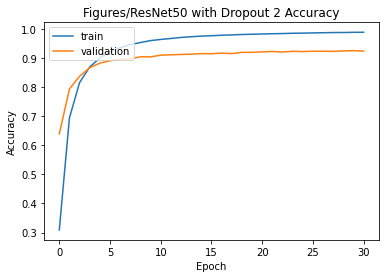

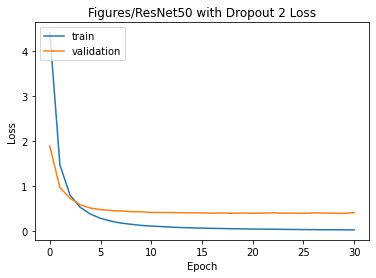

In [116]:
#Show the history of accuracy and loss across epochs.
#Skip this cell if you skipped the previous cell
show_history(history11,'accuracy','Figures/ResNet50 with Dropout 2 Accuracy')
show_history(history11,'loss','Figures/ResNet50 with Dropout 2 Loss')

In [71]:
#Load pretrained weights
resNet_50_drop2.load_weights('Models/ResNet50_Dropout2.h5')
print("Loaded trained weights from disk")

#View performance of the model
resNet_50_drop2_f1 = evaluate_model(resNet_50_drop2,x_train,Y_train,x_test,Y_test)
all_models.append('ResNet50 with Dropout 2')
all_models_f1.append(resNet_50_drop2_f1)

Loaded trained weights from disk
9734/9734 [==============================] - 2s 185us/step

Results

Train loss: 0.37
Train accuracy: 0.93

Test loss: 2.45
Test accuracy: 0.6942675113677979
F1 micro score: 0.6942675159235668


The second ResNet50 model architecture with dropout is the best performing model with an f1 score of 0.694, narrowly outperforming the ResNet34 model with two dropout layers which had an f1 score of 0.689.

Now that we have experimented with 11 different model architectures, we will try different parameters with the second ResNet50 dropout architecture to see if we can further improve its performance.

<a id = 'final_mod'></a>

## Improving ResNet50 Hyperparameters

So far our best performing model is the ResNet50 model with two dropout layers. Achieving an accuracy of approximately 69% and an F1-Micro Score with 0.69.

To try and improve the model's performance, I experimented with different hyperparameters by running 42 different models. By changing the hyperparameters of the ResNet50 model with 2 dropout layers, the model was able to achieve f1-scores as high as 0.76 and 76% test accuracy. Below is the model which achieved this performance:

In [72]:
#Build the model which achieved the best performance 
#out of the 42 total models
resNet50_drop2_optimized = Sequential()
resNet50_drop2_optimized.add(layers.Conv2D(112,13,strides=2,input_shape = input_shape,padding="same",use_bias=False))
resNet50_drop2_optimized.add(layers.BatchNormalization())
resNet50_drop2_optimized.add(layers.Activation('relu'))
resNet50_drop2_optimized.add(layers.MaxPool2D(pool_size=3,strides=2,padding="same"))
resNet50_drop2_optimized.add(layers.Dropout(rate=0.75))

prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256]*6 + [512]*3:
    if prev_filters == filters:
        strides = 1
    else: 
        strides = 2
    resNet50_drop2_optimized.add(ResidualUnit50(filters,strides=strides))
    prev_filters = filters

resNet50_drop2_optimized.add(layers.Dropout(rate=0.75))
resNet50_drop2_optimized.add(layers.AveragePooling2D((2, 2), name='avg_pool'))
resNet50_drop2_optimized.add(layers.Flatten())
resNet50_drop2_optimized.add(layers.Dense(num_classes,activation = "softmax"))

opt = Adam(learning_rate=0.001)

#Compile the model
resNet50_drop2_optimized.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

For this model, I increased the dropout rate to 0.75 for both layers, and increased the number of filters and kernel size of the first convolutional layer. This helped increase the model's performance by approximately 7% accuracy. In the next cell, the model will be fitted to the data. If you would like to skip the training, skip the next two cells to the cell with the code:

    resNet_50_drop2_f1_optimized = evaluate_model('ResNet50_Dropout2_optimized.h5',x_train,Y_train,x_test,Y_test)
            
Please note that if you do decide to train the model, you can view the model's progress as output by setting <i>'verbose = 1'</i> in the cell below. You should also uncomment the line in the next cell to save the new weights.

In [111]:
#Skip this cell if you would like to skip the training

#Train the optimized model (Takes around 10-20 minutes)

#Measure time. Takes around 8-10 minutes to train
start = time.perf_counter()

history12 = resNet50_drop2_optimized.fit(x_train_partial, y_train_partial,
          batch_size=128,
          epochs=100,
          verbose=0,
          validation_data=(x_validation, y_validation),
         callbacks =[early_stop])

#Uncomment the next line to overwrite the pretrained model
#resNet50_drop2_optimized.save('Models/ResNet50_Dropout2_optimized.h5')

finish = time.perf_counter()
print(f'Finished training model in {round(finish-start,2)} seconds')

Finished training model in 1956.34 seconds


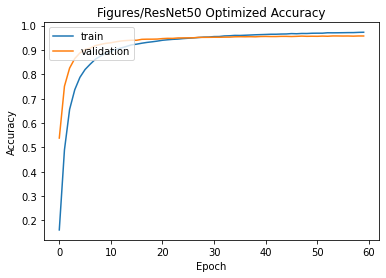

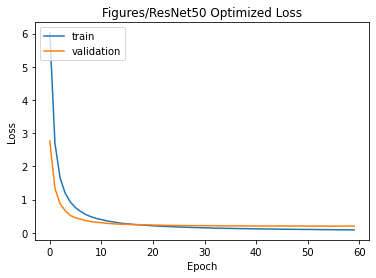

Validation Loss of Nonoptimized model: 0.3990313768681792
Validation Loss of Optimized model: 0.20089700785371445


In [115]:
#Show the history of accuracy and loss across epochs.
#Skip this cell if you have been skipping training so far

show_history(history12,'accuracy','Figures/ResNet50 Optimized Accuracy')
show_history(history12,'loss','Figures/ResNet50 Optimized Loss')

print('Validation Loss of Nonoptimized model:',history11.history['val_loss'][len(history11.epoch)-6])
print('Validation Loss of Optimized model:',history12.history['val_loss'][len(history12.epoch)-6])


In [73]:
#Load pretrained weights
resNet50_drop2_optimized.load_weights('Models/ResNet50_Dropout2_optimized.h5')
print("Loaded trained weights from disk")

#View performance of the model
resNet_50_drop2_f1_optimized = evaluate_model(resNet50_drop2_optimized,x_train,Y_train,x_test,Y_test)

#Save the results
all_models.append('ResNet50 with Dropout 2 Optimized')
all_models_f1.append(resNet_50_drop2_f1_optimized)

Loaded trained weights from disk
9734/9734 [==============================] - 2s 164us/step

Results

Train loss: 0.19
Train accuracy: 0.96

Test loss: 1.76
Test accuracy: 0.7601191401481628
F1 micro score: 0.7601191699198685


A possible reason for why increasing the kernel size and number of filters helped improve the model is because when we increase these values, we are essentially sending more information into the residual units, so the model has more information to process in the residual units, resulting in less information loss. 

We can see this reflected in the plots of the training and validation loss. With the improved model, we can see that the training and validation loss are quite low. In the cell above, we can compare the amount of loss in the optimized model against the original ResNet50 model with two dropout layers and see that the optimized model has a much lower loss now (the optimized model had a loss of 0.2 compared to 0.399 for the non-optimized model).

Finally, we can also see in the accuracy and loss plots, that the gap between training and validation accuracy is very narrow, suggesting that by increasing the dropout, we were able to further reduce overfitting.

<a id = 'conclusion'></a>
# Discussion and Conclusion

In the next cell we can see the F1-scores for all of our models and compare our optimized model to the other CNN architectures and the KNN model. We can see that overall we were able to improve the f1-score originally obtained from the KNN, by approximately 0.26.



<Figure size 1536x1024 with 0 Axes>

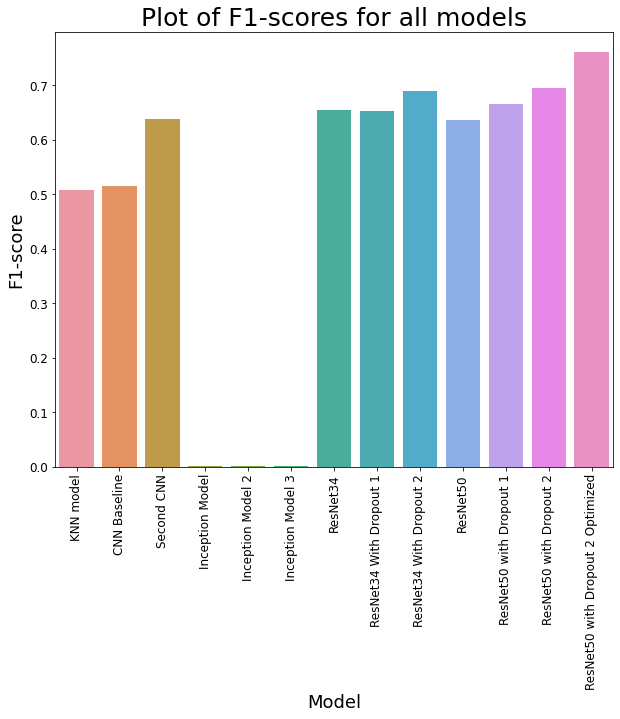

In [75]:
#Plot of average f1-score across classes grouped by number of observations in test data
plt.figure(num=None, dpi=256, facecolor='w', edgecolor='r')
plt.figure(figsize=(10, 8))
f1_score_plot = sns.barplot(x = all_models, y = all_models_f1)

#Adjust the visual parameters of the plot
f1_score_plot.axes.set_title("Plot of F1-scores for all models",fontsize=25)
f1_score_plot.set_xlabel("Model",fontsize=18)
f1_score_plot.set_ylabel("F1-score",fontsize=18)
f1_score_plot.tick_params(labelsize=12)
plt.setp(f1_score_plot.get_xticklabels(), rotation=90)
plt.savefig('Figures/F1 Scores.png')

plt.show()

However, when we examine the model's predictions in more detail, we can see that the model still had a large number of classes which it did not try to predict.

In [76]:
#Get Class predictions for the optimized model
y_pred_optimized = resNet50_drop2_optimized.predict_classes(x_test, verbose=0)

#Collect the Unique class values
y_test_encoded = Y_test.indices
unique_lab = np.unique(y_test_encoded)

#Subtract the class predictions of our model from values in the Y_test 
no_predictions = set(y_test_encoded) - set(y_pred_optimized)

#Get unique character classes and counts of each class
y_test_counted_cnn = count_characters(y_test_encoded)

observations = []
no_predictions = list(no_predictions)

#Get the number of observations for classes that 
#were not predicted by the model
for i in range(0,len(no_predictions)):
    observations.append(y_test_counted_cnn.get(no_predictions[i]))
    
print('Total classes with no predictions:',len(observations))
print(round(len(no_predictions)/2425,4)*100, '% of the total number of classes in the test set had no predictions.')
print('\nMax number of observations in classes with no predictions:',np.max(observations))
print('Min number of observations in classes with no predictions:',np.min(observations))
print('\nAverage number of observations in classes with no predictions:',round(np.mean(observations),2))

print(f'\nMode of observations in classes with no predictions:{stats.mode(observations).mode[0]},',\
      f' with:{stats.mode(observations).count[0]}',\
      f'instances ({round(stats.mode(observations).count[0]/len(observations),2)*100}% of classes)')

print('\nTotal classes in y_test with only a single observation:',single_obs)
print(f'\nThe model did not have any predictions for {stats.mode(observations).count[0]} out of the {single_obs}',\
      f'classes with one observation in the test set ({round(stats.mode(observations).count[0]/single_obs,2)*100}%).')

Total classes with no predictions: 534
22.02 % of the total number of classes in the test set had no predictions.

Max number of observations in classes with no predictions: 4
Min number of observations in classes with no predictions: 1

Average number of observations in classes with no predictions: 1.07

Mode of observations in classes with no predictions:1,  with:502 instances (94.0% of classes)

Total classes in y_test with only a single observation: 942

The model did not have any predictions for 502 out of the 942 classes with one observation in the test set (53.0%).


---
Similar to the KNN model, the optimized ResNet50 did not make any predictions for approximately 22.02% of the 2425 classes in the test set. Out of these classes, The majority (94%) only had a single observation in the test set. The model did not make predictions for 53% of the classes that have only one observation in the test set. 

Because we balanced the training data set, it is unlikely that this is due to an inherit bias in the model, but is more likely to do with the lack of quality data for those classes. A possible solution to this could be to experiment with the parameters for the data augmentation algorithm to try to generate more diverse examples. However, it could also be the case that these characters for which there are very few examples may have been written by different authors, making them vary in appearance and thus make it more difficult to train a model on them with such a limited number of observations.

It is also possible for some premodern cursive characters to be written in very different ways, making them look completely different in appearance. For example, these two images are meant to represent the same character (給):

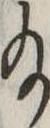




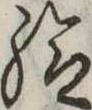

While these kinds of discrepencies typically occur in more common characters, it demonstrates part of the issue. If, for example, there was a case where there was a character like the one above that only had one observation in the test set and one in the training set, it would be difficult to address this kind of issue without collecting more data for this particular class, and near impossible to generate synthetic data from a single image which approximates the corresponding image.

In the next cell we will examine a break down of the f1 scores across the classes. 

In [77]:
#Store our results as a dictionary
resNet50_results = metrics.classification_report(y_test_encoded,y_pred_optimized,output_dict=True,zero_division=1)

#Extract the f1 scores, labels, and number of observations as 3 lists
resNet50_f1_list = []
resNet50_result_labels = []
resNet50_support = []

for i in range(0,len(unique_lab)):
    if(str(unique_lab[i]) in resNet50_results.keys()):
       resNet50_result_labels.append(unique_lab[i])
       resNet50_f1_list.append(resNet50_results.get(str(unique_lab[i])).get('f1-score'))
       resNet50_support.append(resNet50_results.get(str(unique_lab[i])).get('support'))
    
print(examine_f1(resNet50_result_labels,resNet50_f1_list,resNet50_support,1.0,'equal'))
print(examine_f1(resNet50_result_labels,resNet50_f1_list,resNet50_support,0.6,'greater'))
print(examine_f1(resNet50_result_labels,resNet50_f1_list,resNet50_support,0.5,'less'))
print(examine_f1(resNet50_result_labels,resNet50_f1_list,resNet50_support,0.0,'less'))

synth_label_cnn = []
synth_f1_cnn = []

#Get the results for classes that originally had only one 
#non-synthetic observation in the training set
for i in range(0,len(single.indices)):
    if str(single.indices[i]) in resNet50_results.keys():
        synth_label_cnn.append(single.indices[i])
        synth_f1_cnn.append(resNet50_results.get(str(single.indices[i])).get('f1-score'))

#Inspect results of classes that only had 
#one non-synthetic observation in the training set
count = 0
for i in range(0,len(synth_f1_cnn)):
    if synth_f1_cnn[i] == 1.0:
        count+=1

print("Mean f1-score for classes with only one non-synthetic sample in training set:",round(np.mean(synth_f1_cnn),3))
print("Number of classes with only one non-synthetic sample with a perfect f1-score:",count)


Total classes with an f1 score equal to 1.0: 507
Average number of observations per class:2.08

Total classes with an f1 score greater than or equal to 0.6: 1585
Average number of observations per class:5.15

Total classes with an f1 score less than or equal to 0.5: 786
Average number of observations per class:1.64

Total classes with an f1 score less than or equal to 0.0: 626
Average number of observations per class:1.12

Mean f1-score for classes with only one non-synthetic sample in training set: 0.213
Number of classes with only one non-synthetic sample with a perfect f1-score: 74


---

In this example, the ResNet50 model successfully predicted 507 classes perfectly (20.9% of classes). From these classes, the average amount of observations in the test set was 2.08. The model also has an F1 score of 0.6 or more for 1585 classes (approximately 65%) of the classes. 

Conversely, the model had an F1 score less than 0.5 for approximately 786 classes (32.41% of total classes), the majority of which (626) had an f1-score of 0.0. 

In the above example we know that 534 of the 626 classes with f1-scores of 0.0 had no predictions, so there were 92 cases where the model attempted to predict a class, but was unable to correctly classify a single instance of that class. Though there is a possibility that these classes may have been cases where there was only a single observation in the test set, so in such cases the model would have been in an 'all or nothing' type of situation, where it either predicted the class perfectly or not at all.

Finally, we can see that while the average f1-score for our classes that only had a single non-synthetic observation is approximately the same as our KNN model (which was 0.2), the number of such classes with a perfect f1-score has increased. While Our KNN model was only able to classify 49 classes that had a single non-synthetic observation perfectly, our optimized model was able to classify 74 perfectly. Indicating that by increasing the complexity of the model, we were able to correctly classify more classes based on very limited 'organic' data samples.

This is a rather interesting finding. As noted above, the model struggled with some classes which only had a single observation in the test set. However, despite this, the model's performance was improved for classes which had only a single 'real-world' observation in the training set (i.e. one real observation and 99 synthetic ones). 


Below is a plot showing the average f1 score for the classes, where each class is grouped by the number of observations in the test set for that class (support).

<Figure size 1536x1024 with 0 Axes>

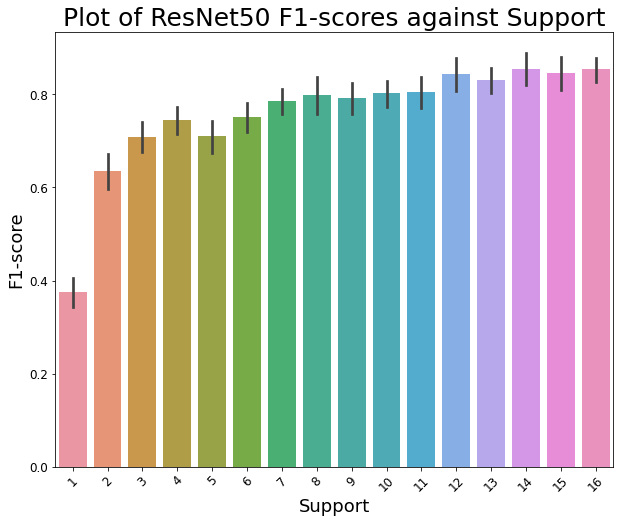

Average scores for ResNet50 with two dropout layers

Average f1-score for classes with one observation: 0.38
Average f1-score for classes with two observations: 0.64


In [78]:
#Plot of average f1-score across classes 
#grouped by number of observations in test data
plt.figure(num=None, dpi=256, facecolor='w', edgecolor='r')
plt.figure(figsize=(10, 8))

resNet50_plot = sns.barplot(x = resNet50_support, y = resNet50_f1_list)

#Adjust the visual parameters of the plot
resNet50_plot.axes.set_title("Plot of ResNet50 F1-scores against Support",fontsize=25)
resNet50_plot.set_xlabel("Support",fontsize=18)
resNet50_plot.set_ylabel("F1-score",fontsize=18)
resNet50_plot.tick_params(labelsize=12)
plt.setp(resNet50_plot.get_xticklabels(), rotation=45)
plt.savefig('Figures/resNet50_plot.png')

plt.show()


print("Average scores for ResNet50 with two dropout layers\n")
print("Average f1-score for classes with one observation:",round(average_f1(1,resNet50_support,resNet50_f1_list),2))
print("Average f1-score for classes with two observations:",round(average_f1(2,resNet50_support,resNet50_f1_list),2))

We can see that aside from the classes with only a single observation in the test set, the model had an average f1 score greater than 0.6 for classes with more than 1 observation.

When we compare this information to the same plot we generated for the KNN model (seen below), we can see an overall improvement in terms of f1 score.

<Figure size 1536x1024 with 0 Axes>

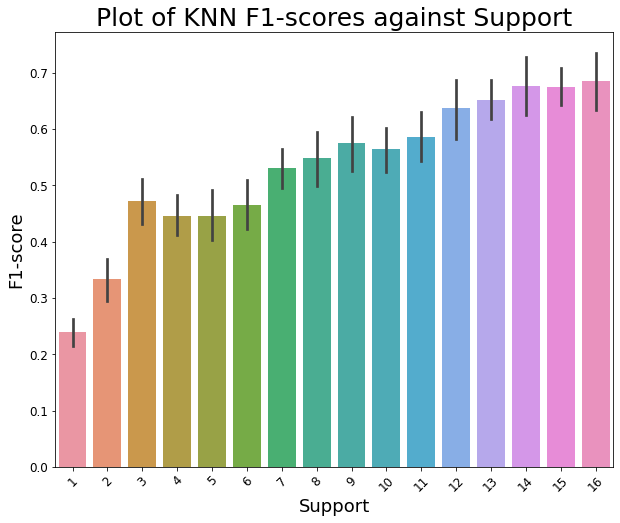

Average scores for KNN
Average f1-score for classes with one observation: 0.24
Average f1-score for classes with two observations: 0.33


In [79]:
#Plot of average f1 scores 
#by number of observations in test classes for KNN
plt.figure(num=None, dpi=256, facecolor='w', edgecolor='r')
plt.figure(figsize=(10, 8))
knn_plot2 = sns.barplot(x = knn_support, y = knn_f1_list)

#Adjust the visual parameters of the plot
knn_plot2.axes.set_title("Plot of KNN F1-scores against Support",fontsize=25)
knn_plot2.set_xlabel("Support",fontsize=18)
knn_plot2.set_ylabel("F1-score",fontsize=18)
knn_plot2.tick_params(labelsize=12)
plt.setp(knn_plot2.get_xticklabels(), rotation=45)

plt.show()

print("Average scores for KNN")
print("Average f1-score for classes with one observation:",round(average_f1(1,knn_support,knn_f1_list),2))
print("Average f1-score for classes with two observations:",round(average_f1(2,knn_support,knn_f1_list),2))

---
## Conclusion

The Kuzushiji data set poses a unique challenge due to the large number of different characters, the variation in form that some characters may take, and the major imbalance in terms of class frequency, with the most frequent character having over 41,000 observations and 790 classes having only one observation. This project aimed to provide visualization into the distribution of this data and develop an image classifier for interpreting these premodern cursive characters as modern Japanese characters by focusing on the characters that fall within the interquartile range in terms of frequency.

By focusing on the IQR, we were able to direct our attention to the less commonly occuring written characters and focus on developing a model for dinstinguishing between them. Specifically, we were able to demonstrate that with the help of the generation of synthetic data, a complex model can be trained on very limited real world data, and in some cases on just a single real world observation.

While our final ResNet50 model struggled with some minority classes which were under-represented in the test set, by generating synthetic data and experimenting with different machine learning and deep learning models, we were able to develop a solution capable of classifying the kuzushiji cursive script into 2425 classes with approximately 76% accuracy based on very few real observations. 

<a id = 'references'></a>
# References

1. Clanuwat, T., Bober-Irizar, M., Kitamoto, A., Lamb, A., Yamamoto, K., & Ha, D.(2018). Deep Learning for Classical Japanese Literature. [arXiv:1812.01718v1](https://arxiv.org/abs/1812.01718)


2. Geron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow (2nd Edition). O'Reilly


3. He, K., Zhang, X., Ren, S., & Sun, J.(2015). Deep Residual Learning for Image Recognition. arXiv preprint [arXiv:1512.03385v1](https://arxiv.org/abs/1512.03385)


4. Szegedy, C., Liu, W., Jia, Y., Sermanet, P., Reed, S., Anguelov, D., Erhan, D., Vanhoucke, V., & Rabinovich, A. (2015). [Going Deeper with Convolutions.](https://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Szegedy_Going_Deeper_With_2015_CVPR_paper.html) <i>Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition</i>, pp 1-9

<a href = '#top'>...Back to the top</a>